In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

animal = 'AE_293'

ops_directory = 'D:\\OpsinTest_Cache'
beh_directory = 'Z:\\Behavioor'


stdfont = 14
stdyfrac = 0.06

In [2]:
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(ops_directory)



for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.animal == 'AE_293':
        
        EnumM2Session.append(session)



100%|██████████| 8/8 [00:00<00:00, 136.28it/s]


In [3]:
EnumM2Session

['AE_293_1_passive_M2.pickle',
 'AE_293_2_passive_M2.pickle',
 'AE_293_3_passive_M2.pickle']

In [7]:
sessionfile0.clusters.list

array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  36,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  89,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 119, 120, 121, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 133, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 19

In [8]:
sessionfile0.clusters.noise

array([  0,   1,   2,   5,   6,   7,   8,   9,  10,  12,  13,  15,  16,
        20,  21,  23,  26,  27,  30,  32,  33,  34,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  58,  59,  63,  64,  66,
        67,  71,  74,  76,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        91,  93,  94,  97,  98,  99, 100, 104, 105, 106, 110, 112, 116,
       121, 123, 124, 128, 129, 135, 136, 138, 142, 143, 144, 149, 151,
       152, 154, 155, 157, 158, 159, 160, 161, 162, 163, 165, 167, 168,
       173, 175, 176, 182, 183, 184, 185, 187, 190, 191, 195, 199, 202,
       203, 204, 206, 207, 212, 213, 214, 216, 217, 218, 220], dtype=int64)

In [9]:
sessionfile0_all_clust = np.setdiff1d(sessionfile.clusters.list, sessionfile.clusters.noise)

In [10]:
sessionfile0_all_clust

array([ 14,  59,  62,  90,  96,  97, 104, 107, 108, 111, 124, 140, 160,
       167, 169, 170, 179], dtype=int64)

In [4]:
sessionfile0 = ilep.loadSessionCached(ops_directory,EnumM2Session[0])
sessionfile1 = ilep.loadSessionCached(ops_directory,EnumM2Session[1])
sessionfile2 = ilep.loadSessionCached(ops_directory,EnumM2Session[2])

In [5]:
sessfionfile0_labels = sessionfile0.clusters.labels
sessionfile0_goodcells = [num for num, label in sessfionfile0_labels.items() if label == 'good']

sessfionfile1_labels = sessionfile1.clusters.labels
sessionfile1_goodcells = [num for num, label in sessfionfile1_labels.items() if label == 'good']

sessfionfile2_labels = sessionfile2.clusters.labels
sessionfile2_goodcells = [num for num, label in sessfionfile2_labels.items() if label == 'good']

In [15]:
def getTrialSpikes(sessionfile,clust):
    trialSpikes = []
    for laser_start in sessionfile_laser_start:
 
        starttime = laser_start - 0.05*30000
        endtime = laser_start + 0.15*30000
        this_trial_spike = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime, endtime=endtime)
        this_trial_spike= this_trial_spike.astype(int)
        print('this_trial_spike:'+str(this_trial_spike))
        # if len(this_trial_spike):
        print(this_trial_spike.astype(int))
        print('laser_start:'+str(laser_start))
        spiketoplot =  (this_trial_spike) - (laser_start)
        print('spiketoplot:'+str(spiketoplot))
        trialSpikes.append(spiketoplot)
    trialSpikes = np.array(trialSpikes,dtype='object') 
    
    print(clust)
    print(trialSpikes)
    
    return trialSpikes

In [24]:
sessionfile0.trials.laser_events[0]

array([ 206812,  299660,  392555,  485415,  578281,  671139,  763998,
        856866,  949719, 1042569, 1431255, 1640937, 1850633, 2060337,
       2270021, 2479685, 2689360, 2899047, 3108780, 3318492], dtype=uint32)

In [25]:
sessionfile1.trials.laser_events[0]

array([  36821,  129737,  222623,  315535,  408444,  501349,  594251,
        687179,  780124,  873021, 1637755, 1847568, 2057366, 2267157,
       2476976, 2686769, 2896588, 3106405, 3316201, 3526003], dtype=uint32)

In [26]:
(129737-36821) / 30000

3.0972

In [27]:
(222623 - 129737)/30000

3.0962

In [28]:
sessionfile1_laser_start

array([ 36821, 129737, 222623, 315535, 408444, 501349, 594251, 687179,
       780124, 873021], dtype=uint32)

In [29]:
sessionfile2.trials.laser_events[0]

array([ 125804,  218712,  311615,  404540,  497439,  590342,  683264,
        776183,  869106,  962010, 1829847, 2039682, 2249488, 2459310,
       2669102, 2878886, 3088713, 3298531, 3508353, 3718179], dtype=uint32)

In [30]:
sessionfile2_laser_start

array([125804, 218712, 311615, 404540, 497439, 590342, 683264, 776183,
       869106, 962010], dtype=uint32)

In [31]:
sessionfile2.trials.laser_events[0]

array([ 125804,  218712,  311615,  404540,  497439,  590342,  683264,
        776183,  869106,  962010, 1829847, 2039682, 2249488, 2459310,
       2669102, 2878886, 3088713, 3298531, 3508353, 3718179], dtype=uint32)

### laser time = 0.1s

In [6]:
sessionfile0_laser_start = sessionfile0.trials.laser_events[0][:10]

sessionfile1_laser_start = sessionfile1.trials.laser_events[0][:10]

sessionfile2_laser_start = sessionfile2.trials.laser_events[0][:10]

In [20]:
def visualizeClusterInternal_short(sessionfile,clust,sessionfile_laser_start): #(-50 to 150ms)
    bw_scott_factor = 3
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xlim([-1500,4500]) #[0.05*30000,0.15*30000]
    
    
    color_to_use = 'black'

    #########################

    trialSpikes = []
    for laser_start in sessionfile_laser_start:
 
        starttime = laser_start - 0.05*30000
        endtime = laser_start + 0.15*30000
        this_trial_spike = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime, endtime=endtime)
        this_trial_spike= this_trial_spike.astype(int)
        spiketoplot =  (this_trial_spike) - (laser_start)
        trialSpikes.append(spiketoplot)
        
    trialSpikes = np.array(trialSpikes,dtype='object') 
    print(trialSpikes)
    #Plot Raster
    for idx,trial in enumerate(sessionfile_laser_start):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=color_to_use,s=2,marker='o',lw=0)    

    
    #Plot PSTH
    starttime = -1500
    endtime = 4500
    PSTHstart = starttime - 50
    PSTHend = endtime + 50
    xrange = np.linspace(starttime,endtime,num=1000)
    numSplits = min(10,len(trialSpikes))
    if numSplits < 2:
        return False,[] ### Return a failure
    
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR,lw=1,color=color_to_use)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.5,zorder=-10,lw=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit])
    ax2.set_yticklabels(['0',str(limit)])
    
    
    ax2.set_ylabel('Firing rate (spikes/s)')
    ax2.plot([0,3000],[limit,limit],color='k',lw=2,linestyle='-') #zorder = 10 line of tone

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([-1500,0,1500,3000,4500])
    ax2.set_xticklabels(['-50','0','50','100','150'])
    ax2.set_xlabel('Time (ms)')
    

    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\AE_M2Test\\1\\'+str(clust)+'short'+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\AE_M2Test\\2\\'+str(clust)+'short'+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\AE_M2Test\\3\\'+str(clust)+'short'+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    
    return fig,[ax1,ax2]

    
    

In [9]:
sessionfile0_goodcells

[19, 22, 25, 28, 36, 56, 57, 95, 111, 137, 141, 171, 179, 205, 222]

In [10]:
sessionfile1_goodcells #remove 134, 138

[108, 134, 138, 161, 170]

In [11]:
sessionfile1_goodcells =[108, 161, 170]

In [12]:
sessionfile2_goodcells

[13, 15, 32, 54, 55, 141, 147, 156, 185, 187]

In [13]:
sessionfile2_goodcells = [15, 32, 54, 55, 141, 147, 156, 185, 187] #remove 13

[array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)
 array([], dtype=int32) array([85]) array([], dtype=int32)
 array([], dtype=int32) array([], dtype=int32) array([1506])
 array([-1068])]


meta NOT subset; don't know how to subset; dropped


[array([], dtype=int32) array([2464]) array([-479]) array([-1002])
 array([776]) array([-1212, -1088]) array([1008]) array([], dtype=int32)
 array([376]) array([], dtype=int32)]


meta NOT subset; don't know how to subset; dropped


[array([-1091,  -389,  1095,  1396,  1729,  2042,  2173,  2392,  3166,
         3446,  3751,  3973,  4351])
 array([-1268,  -818,  -319,   253,   440,   707,   896,  1157,  1571,
         2175,  2633,  3041,  3992,  4329])
 array([-1254,  -872,   336,   577,   769,  1292,  1556,  1850,  2107,
         2310,  2552,  2847,  3159,  3500,  4272])
 array([-603, -399, -261,   60,  251,  360,  596,  821, 1219, 1723])
 array([ 340,  574,  765, 1100, 1270, 1621, 2044, 2407, 2758, 3248, 3640,
        4009, 4378])
 array([-998,  375,  902, 1142, 1896, 2322, 2716, 3125, 3551, 3907, 4305])
 array([1226, 2859, 3983])
 array([-1458,  -906,  -450,    64,   364,   679,  1069,  1527,  1723,
         1888,  2059,  2366,  2600,  3044,  3301,  3551,  3775,  4163])
 array([-264, 3080, 3506, 3960])
 array([-693, -369,  347,  632,  913, 1253, 1661, 1935, 2399, 2874, 3329])]


meta NOT subset; don't know how to subset; dropped


[array([1747, 2192]) array([3675]) array([], dtype=int32)
 array([], dtype=int32) array([40]) array([], dtype=int32)
 array([2354, 3785, 4158]) array([], dtype=int32) array([3391])
 array([-384])]


meta NOT subset; don't know how to subset; dropped


[array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)
 array([-751,   32]) array([], dtype=int32) array([-715,  257, 3618])
 array([1171, 1334, 2296, 2574, 3100, 3206, 3866, 4312])
 array([], dtype=int32) array([2137, 2878, 3499, 4096])
 array([-474, 1960, 3573])]


meta NOT subset; don't know how to subset; dropped


[array([1748]) array([1135, 2865]) array([-177, 2131, 4460])
 array([-1392,  -117]) array([-885,  714, 3901]) array([], dtype=int32)
 array([1433]) array([2032, 2684, 3451, 4392]) array([-293, 1412])
 array([-1120,  3019])]


meta NOT subset; don't know how to subset; dropped


[array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)
 array([-82]) array([], dtype=int32) array([-551, 1435])
 array([1182, 3459]) array([-540, 1907, 3337]) array([2779]) array([4088])]


meta NOT subset; don't know how to subset; dropped


[array([12]) array([-896, -151,  266, 2122, 2229]) array([937])
 array([-771, -174, 1035, 1388]) array([ -85, 2994]) array([-1386])
 array([  -4, 3636]) array([  12, 2123, 3036]) array([1939, 2532])
 array([], dtype=int32)]


meta NOT subset; don't know how to subset; dropped


[array([-1174,  2157,  2400]) array([-1052,   267,   758,  1921,  4287])
 array([-1368,  -611,  2639,  3747,  4069]) array([-308,  328])
 array([-483, -199,   95, 1424, 3659]) array([-1403, -1159,   378])
 array([ 698,  883, 1050, 4465]) array([-858, 2251, 3376, 3643])
 array([2216, 2656, 3929]) array([ 497,  712, 3099])]


meta NOT subset; don't know how to subset; dropped


[array([], dtype=int32) array([], dtype=int32) array([-981])
 array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)
 array([2177]) array([], dtype=int32) array([2700]) array([], dtype=int32)]


meta NOT subset; don't know how to subset; dropped


[array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)
 array([-9]) array([ -91,   -9, 3193]) array([], dtype=int32)
 array([1918]) array([-1056,    -8]) array([-526]) array([1562])]


meta NOT subset; don't know how to subset; dropped


[array([-1297,  -727]) array([1909]) array([], dtype=int32)
 array([-58, 418]) array([4258]) array([-1449]) array([3835])
 array([], dtype=int32) array([2453, 3240]) array([2196])]


meta NOT subset; don't know how to subset; dropped


[array([-1108,  1307]) array([  15, 2346, 3961, 4176]) array([301])
 array([-847,  -59, 1271]) array([-924, 4043]) array([-330, 1826])
 array([1303, 2295, 4066]) array([-991, 2469])
 array([2053, 2281, 2483, 2643]) array([ 898, 3871])]


meta NOT subset; don't know how to subset; dropped


[array([-1424]) array([1346, 2577, 3091, 3510]) array([2092])
 array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)
 array([3409]) array([-1343]) array([2246, 2630, 2836, 3088, 3281])
 array([1295, 4315])]


meta NOT subset; don't know how to subset; dropped


[array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)
 array([], dtype=int32) array([], dtype=int32)
 array([-1086,  -664,   -92]) array([2638, 3827, 4471])
 array([], dtype=int32) array([], dtype=int32)
 array([1000, 2288, 3090, 3857])]


meta NOT subset; don't know how to subset; dropped


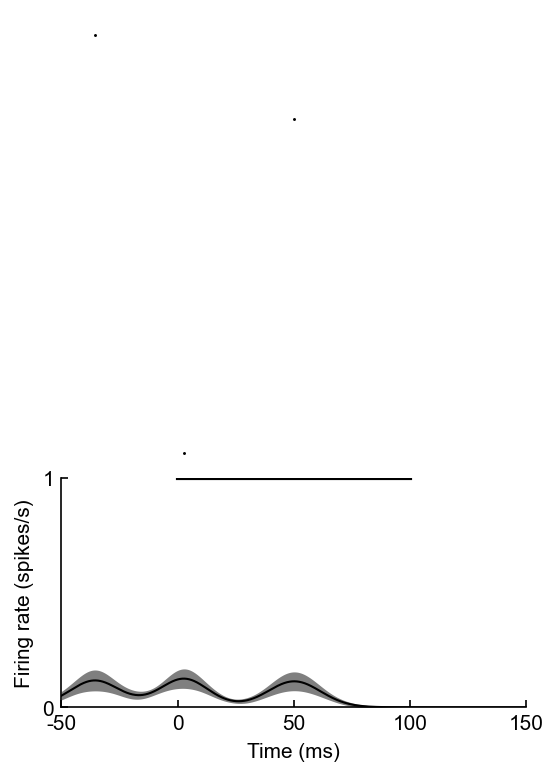

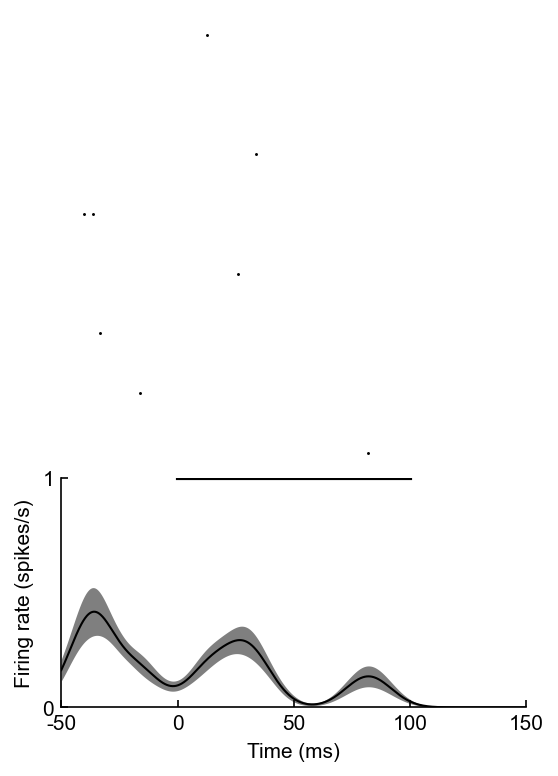

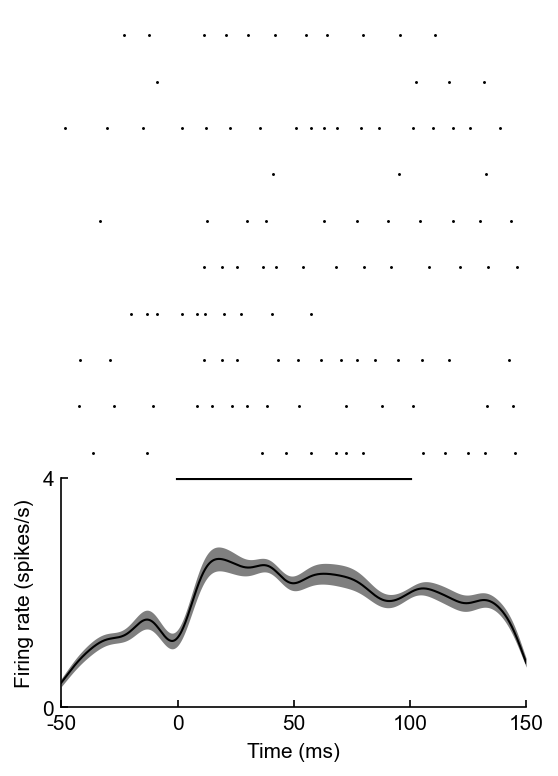

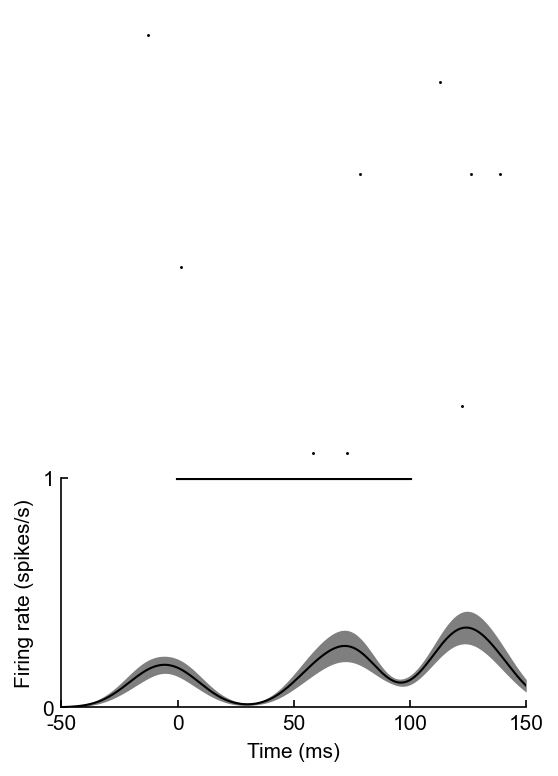

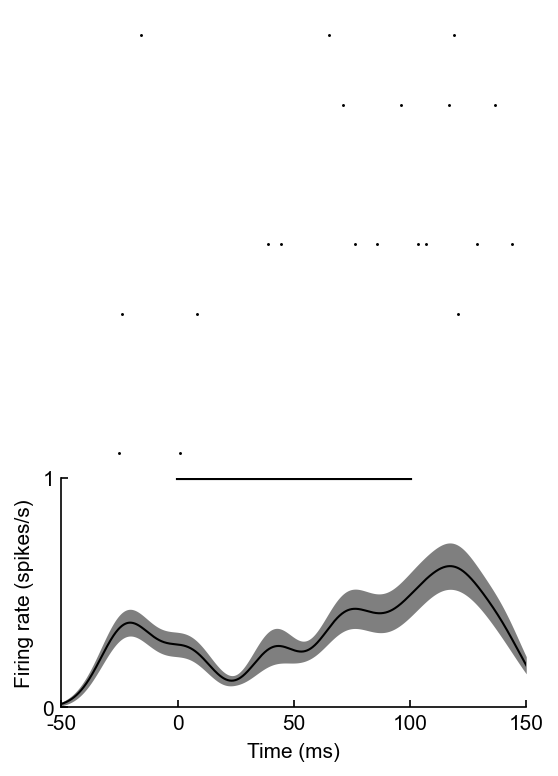

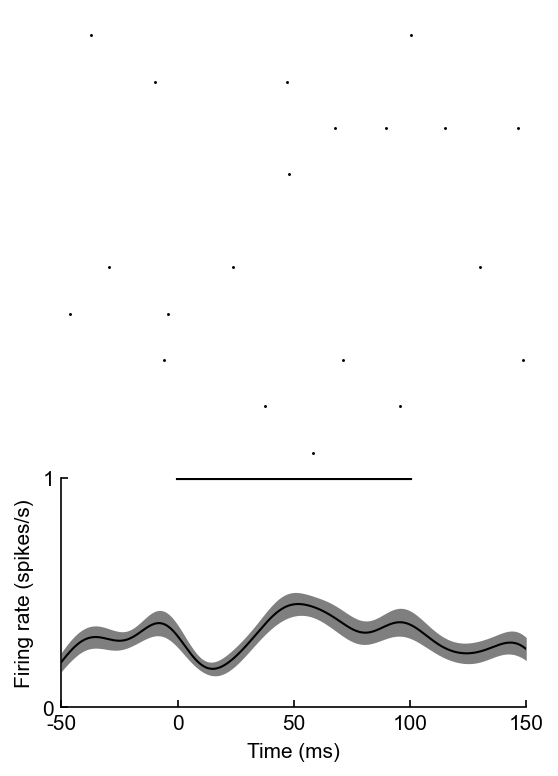

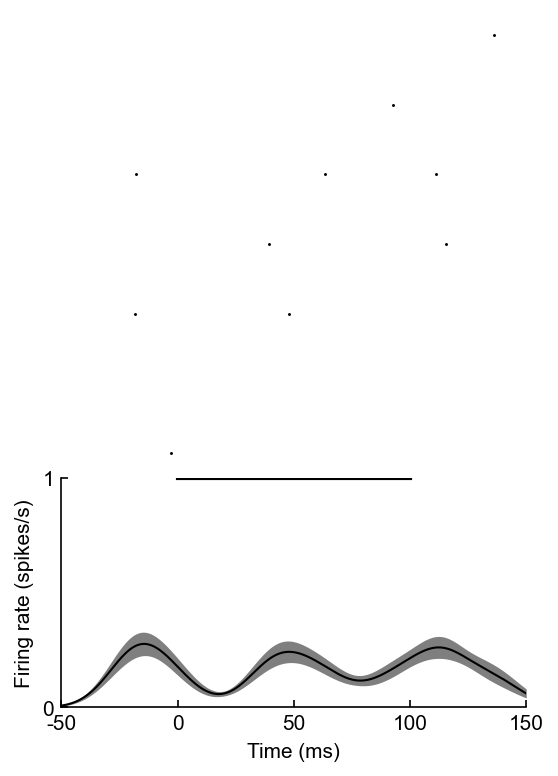

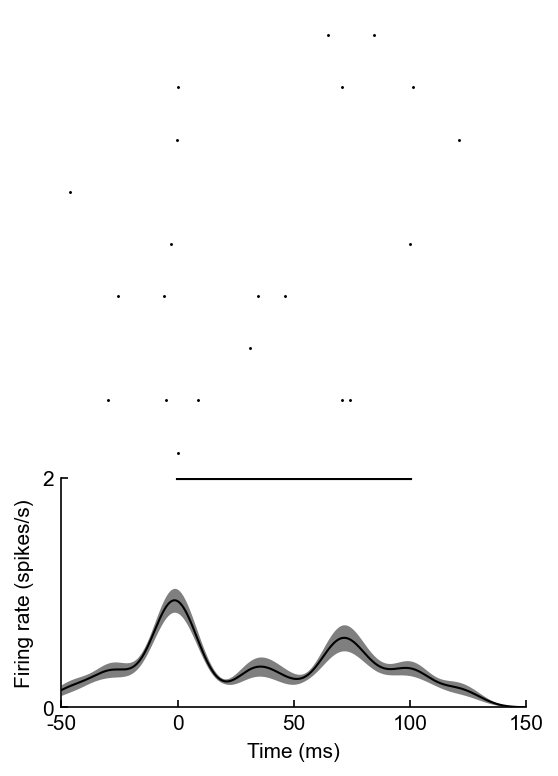

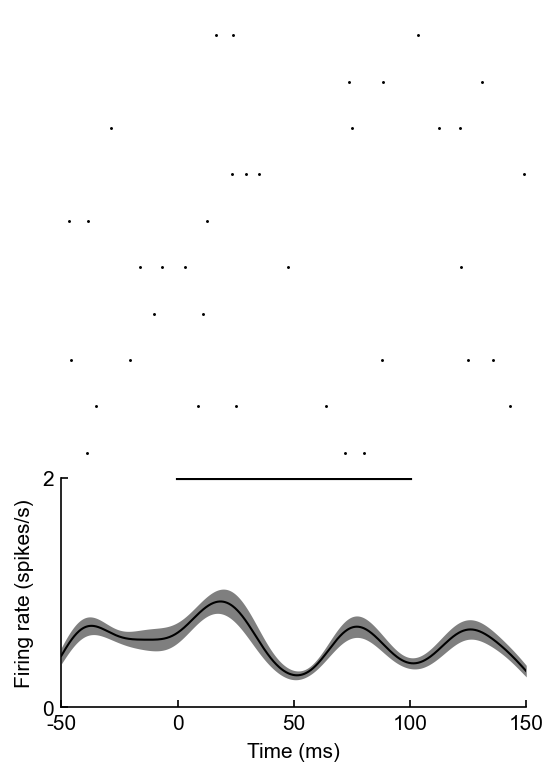

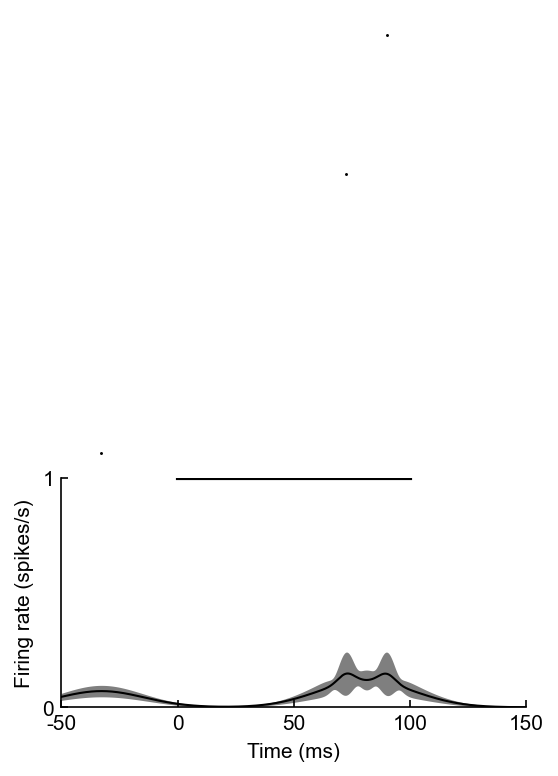

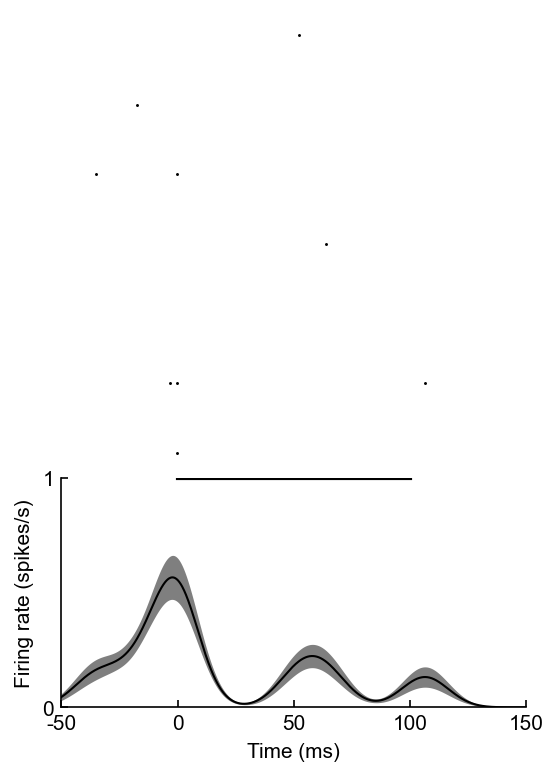

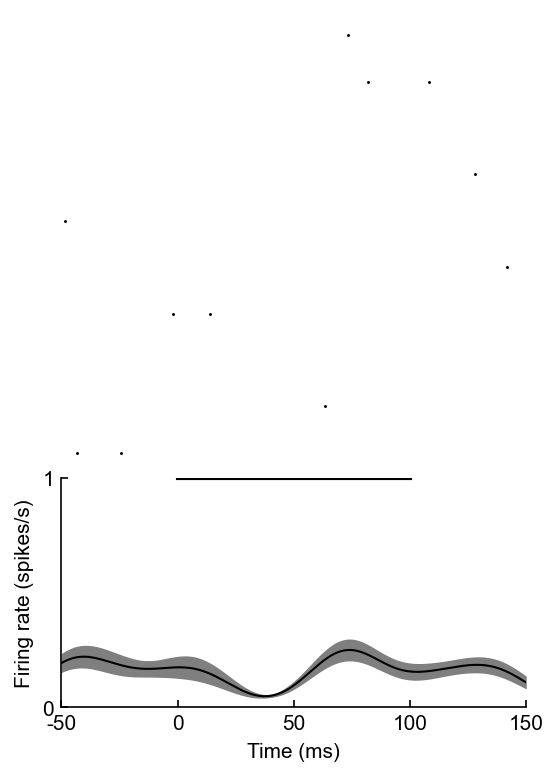

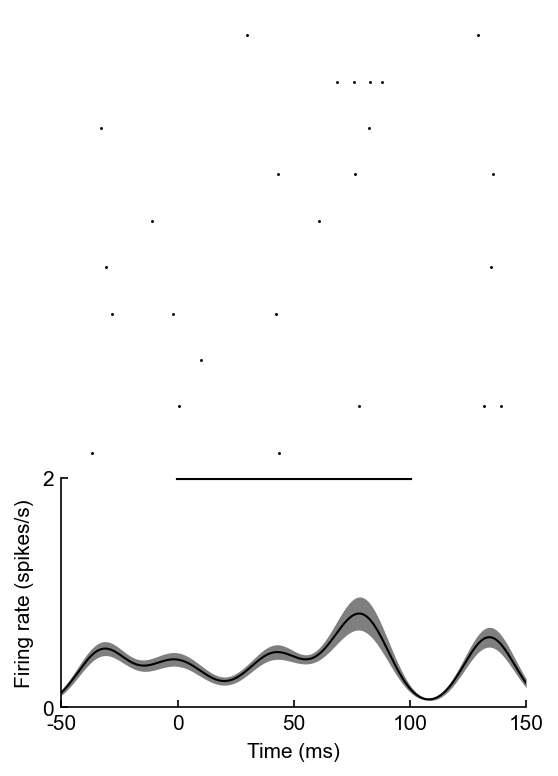

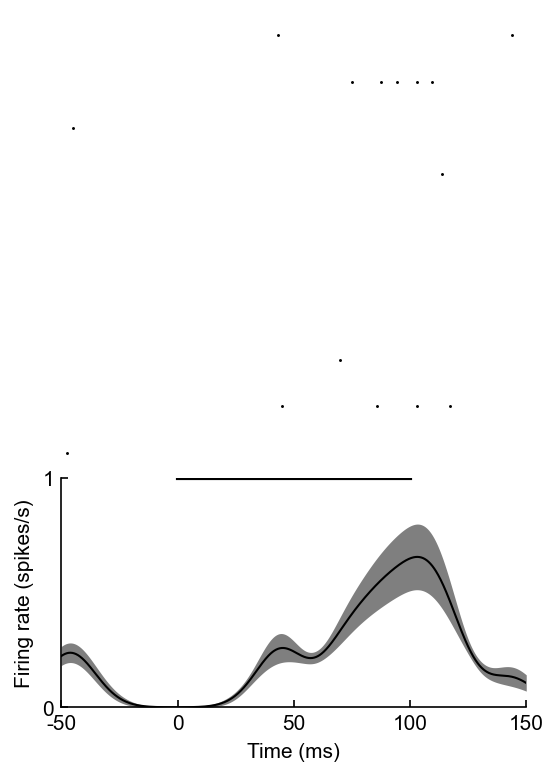

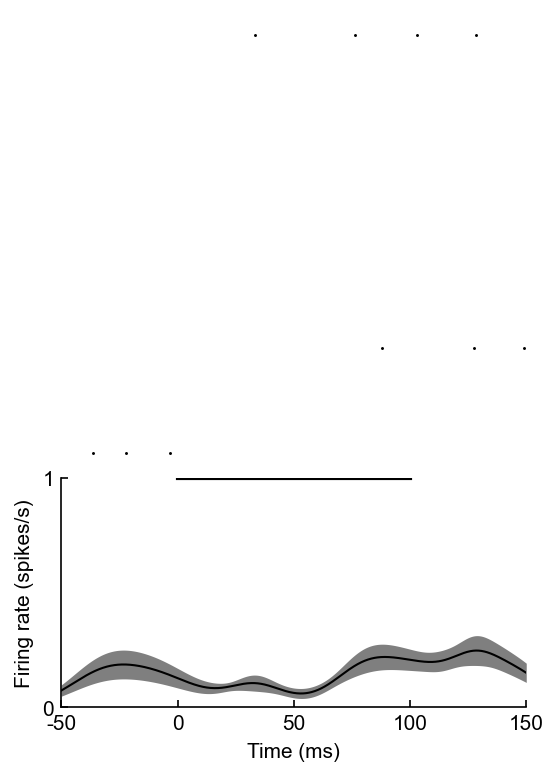

In [17]:
for clust in sessionfile0_goodcells:
    visualizeClusterInternal_short(sessionfile0,clust,sessionfile0_laser_start)

[array([4253]) array([2635]) array([-628, 3147]) array([2408, 3404])
 array([-1401,   859]) array([-916, 2790]) array([3600, 4269])
 array([2891]) array([  72, 1890, 2251, 3606, 3995, 4246, 4441])
 array([-545])]


meta NOT subset; don't know how to subset; dropped


[]


meta NOT subset; don't know how to subset; dropped


[array([-1245]) array([], dtype=int32) array([], dtype=int32)
 array([], dtype=int32) array([107]) array([], dtype=int32) array([-1328])
 array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)]


meta NOT subset; don't know how to subset; dropped


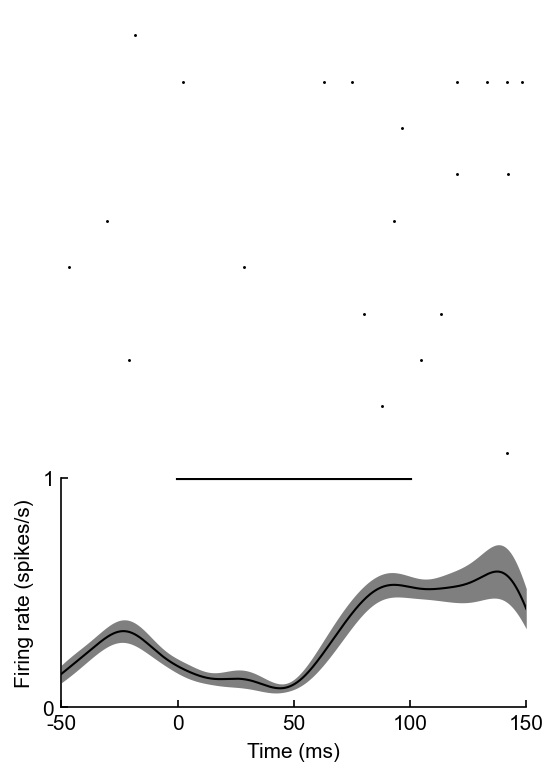

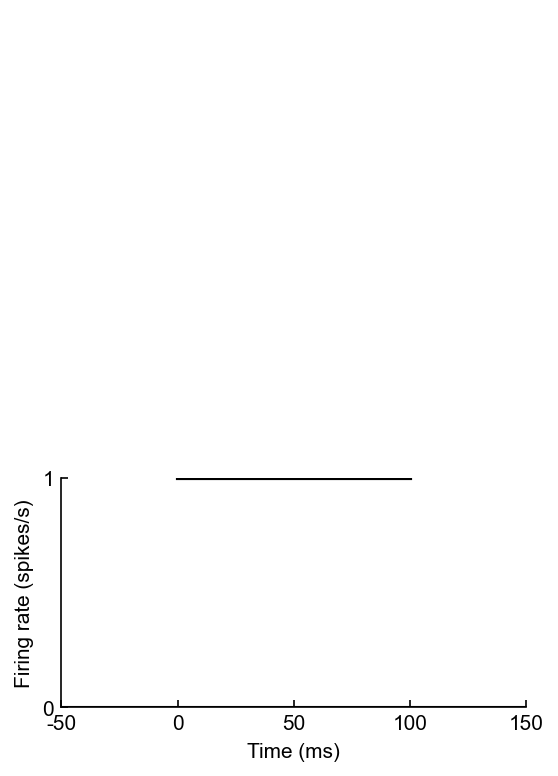

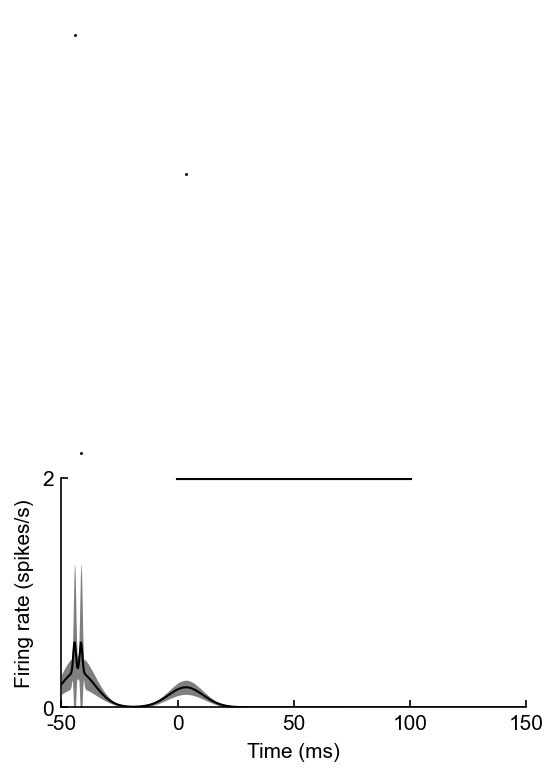

In [19]:
for clust in sessionfile1_goodcells:
    visualizeClusterInternal_short(sessionfile1,clust,sessionfile1_laser_start)

[array([-1196,   345,  2943]) array([   2, 3837, 4270]) array([789])
 array([ 584, 1378]) array([], dtype=int32) array([], dtype=int32)
 array([1836]) array([-209,    3, 4309]) array([ 145, 1686])
 array([  49, 2789])]


meta NOT subset; don't know how to subset; dropped


[array([2232]) array([], dtype=int32) array([1807]) array([2036])
 array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)
 array([3541, 3805, 3935, 4092]) array([-543, 3840])
 array([], dtype=int32)]


meta NOT subset; don't know how to subset; dropped


[array([-839]) array([4490]) array([], dtype=int32) array([2521])
 array([], dtype=int32) array([1218, 3019, 3671, 4482])
 array([ 553, 1966, 3362]) array([2209]) array([], dtype=int32)
 array([ 853, 2468, 3891])]


meta NOT subset; don't know how to subset; dropped


[array([], dtype=int32) array([], dtype=int32) array([], dtype=int32)
 array([2493]) array([245, 471]) array([1290]) array([ 885, 2349, 2448])
 array([ 730, 2204, 2438, 2786]) array([ 267,  985, 2272])
 array([ 251, 3833])]


meta NOT subset; don't know how to subset; dropped


[array([183]) array([3128]) array([-1273]) array([1064, 1959])
 array([1439]) array([1594]) array([], dtype=int32) array([361])
 array([3251]) array([4328])]


meta NOT subset; don't know how to subset; dropped


[array([1933, 4077]) array([], dtype=int32) array([], dtype=int32)
 array([], dtype=int32) array([1808, 2905]) array([ 338, 3000])
 array([-576]) array([], dtype=int32) array([], dtype=int32) array([1822])]


meta NOT subset; don't know how to subset; dropped


[array([-961, -219,  474, 1275, 1843, 2803]) array([3620])
 array([ 427,  781, 2377])
 array([ 374,  955, 1817, 2189, 2538, 2791, 2963])
 array([ 554, 1242, 2361, 3206])
 array([-714, -153,  326,  621,  976, 1731, 1972, 3831])
 array([-772,  140,  506,  838, 1077, 1302]) array([], dtype=int32)
 array([1141]) array([1370, 2250, 4093])]


meta NOT subset; don't know how to subset; dropped


[array([-1231]) array([], dtype=int32) array([], dtype=int32)
 array([3705]) array([], dtype=int32) array([], dtype=int32)
 array([-666, 1202]) array([], dtype=int32) array([], dtype=int32)
 array([4099])]


meta NOT subset; don't know how to subset; dropped


[array([ 365, 2714]) array([], dtype=int32) array([2889]) array([1165])
 array([2858]) array([3085]) array([2435]) array([ 362, 1669])
 array([3154]) array([3481])]


meta NOT subset; don't know how to subset; dropped


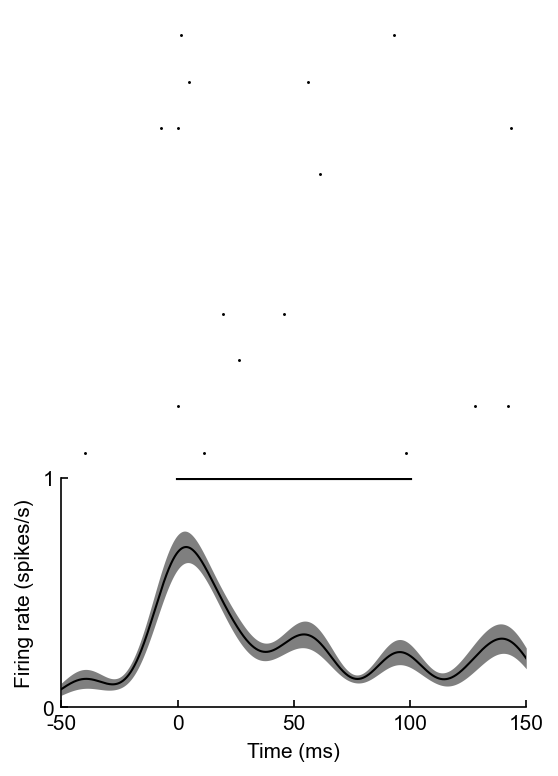

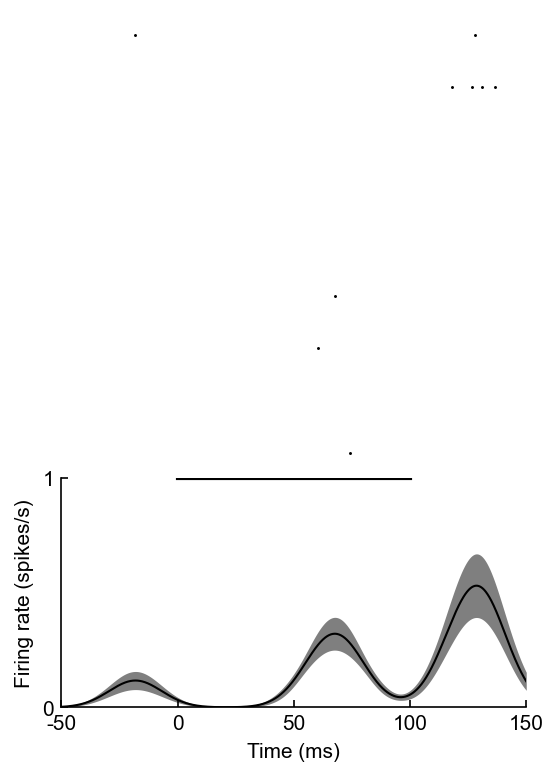

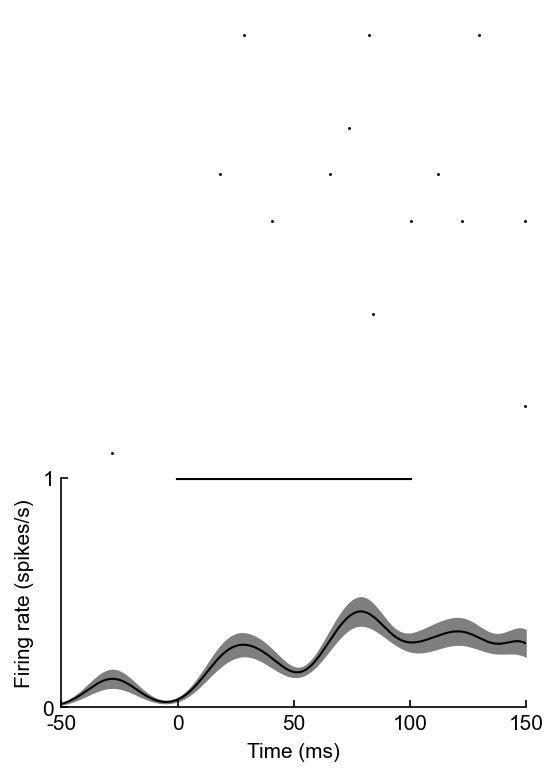

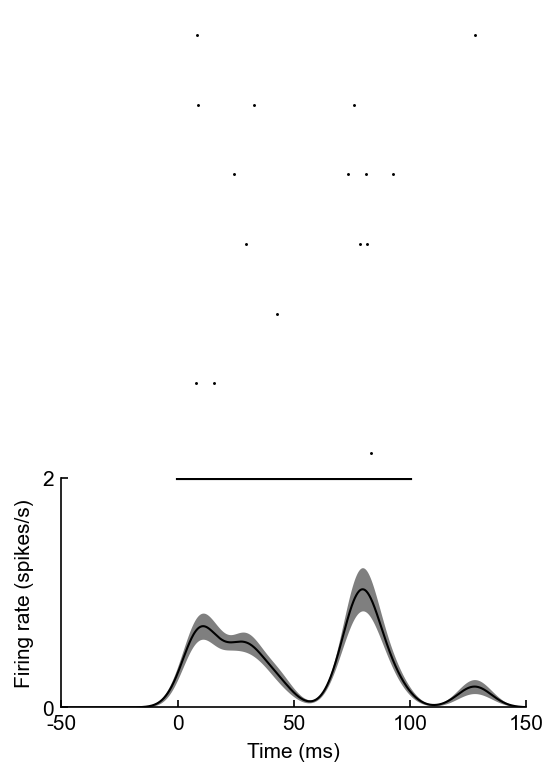

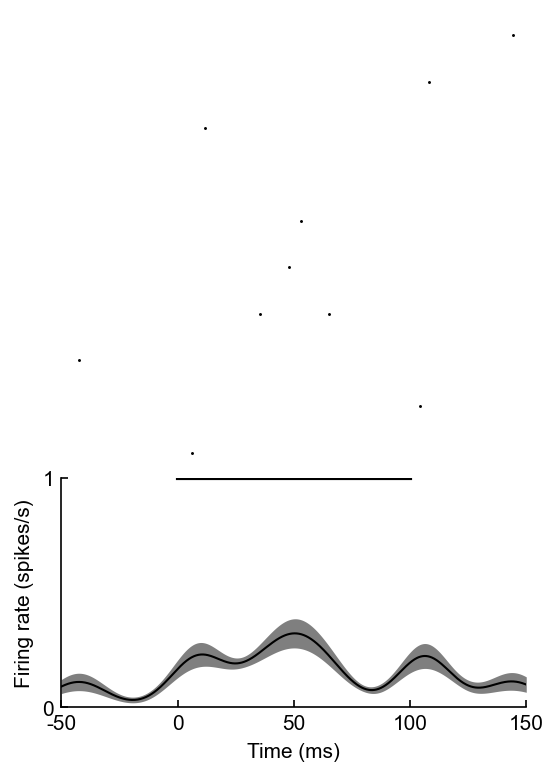

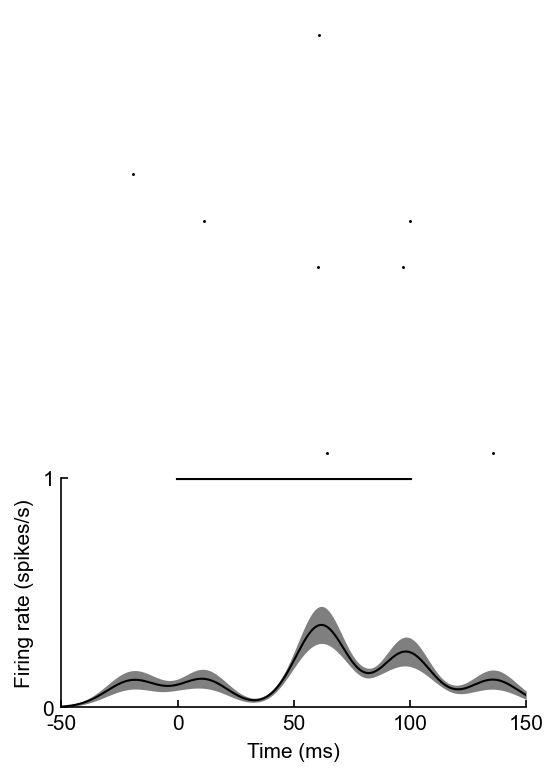

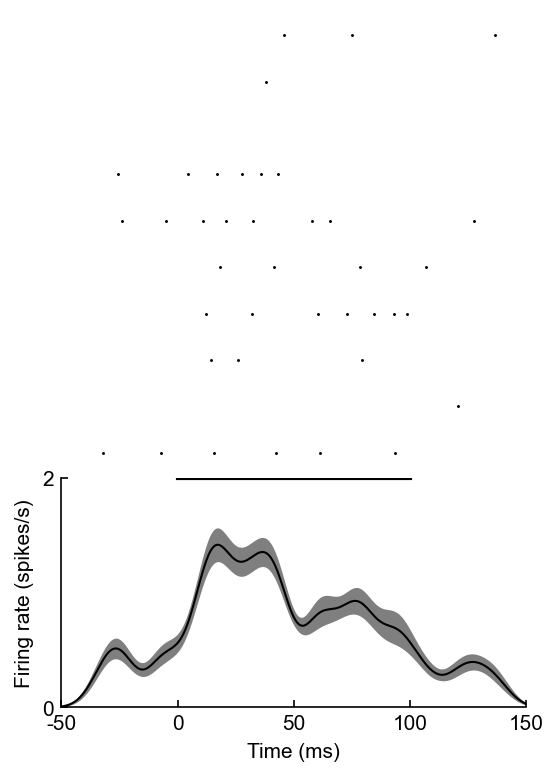

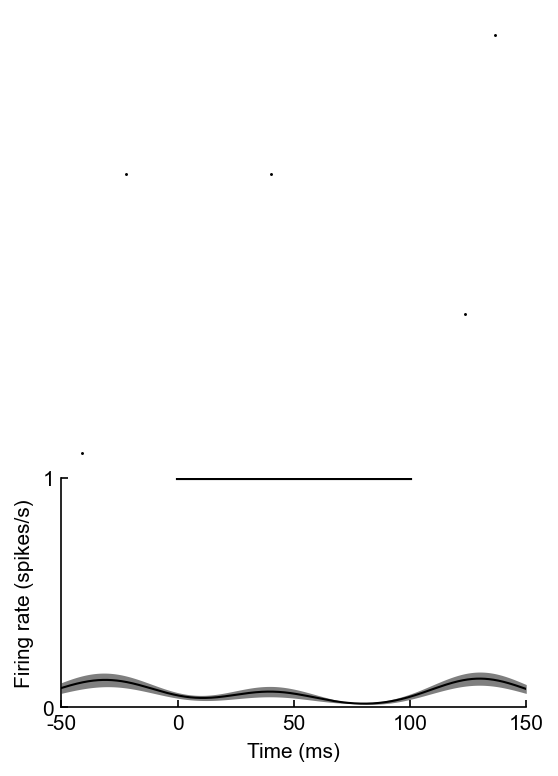

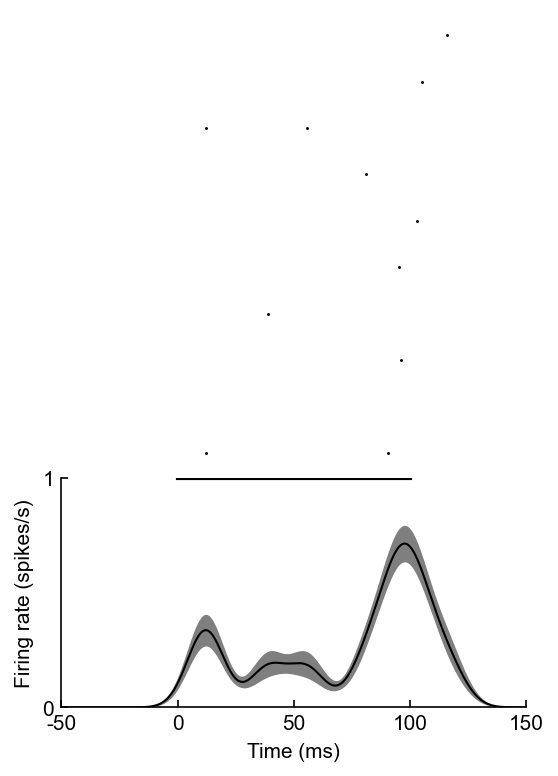

In [21]:
for clust in sessionfile2_goodcells:
    visualizeClusterInternal_short(sessionfile2,clust,sessionfile2_laser_start)

In [64]:
###Longer time (-100 to 200ms)

In [20]:
def visualizeClusterInternal_short2(sessionfile,clust,sessionfile_laser_start):
    bw_scott_factor = 3
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xlim([-3000,6000]) #[0.05*30000,0.15*30000]
    
    
    color_to_use = 'black'

    #########################

    trialSpikes = []
    for laser_start in sessionfile_laser_start:
 
        starttime = laser_start - 0.1*30000
        endtime = laser_start + 0.2*30000
        this_trial_spike = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime, endtime=endtime)
        this_trial_spike= this_trial_spike.astype(int)
        spiketoplot =  (this_trial_spike) - (laser_start)
        trialSpikes.append(spiketoplot)
        
    trialSpikes = np.array(trialSpikes,dtype='object') 
    #print(trialSpikes)
    #Plot Raster
    for idx,trial in enumerate(sessionfile_laser_start):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=color_to_use,s=2,marker='o',lw=0)    

    
    #Plot PSTH
    starttime = -3000
    endtime = 6000
    PSTHstart = starttime - 50
    PSTHend = endtime + 50
    xrange = np.linspace(starttime,endtime,num=1000)
    numSplits = min(10,len(trialSpikes))
    if numSplits < 2:
        return False,[] ### Return a failure
    
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR,lw=1,color=color_to_use)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.5,zorder=-10,lw=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit])
    ax2.set_yticklabels(['0',str(limit)])
    
    
    ax2.set_ylabel('Firing rate (spikes/s)')
    ax2.plot([0,3000],[limit,limit],color='k',lw=2,linestyle='-') #zorder = 10 line of tone

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([-3000,0,3000,6000])
    ax2.set_xticklabels(['-100','0','100','200'])
    
    # ax2.set_xlim([-1500,4500])
    # ax2.set_xticks([-1500,0,1500,3000,4500])
    # ax2.set_xticklabels(['-50','0','50','100','150'])
    # ax2.set_xlabel('Time (ms)')
    

    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\AE_M2Test\\1\\'+str(clust)+'short2'+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\AE_M2Test\\2\\'+str(clust)+'short2'+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\AE_M2Test\\3\\'+str(clust)+'short2'+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    
    return fig,[ax1,ax2]

    

In [36]:
sessionfile2_goodcells

[13, 15, 32, 54, 55, 141, 147, 156, 185, 187]

[array([ 365, 2714]) array([], dtype=int32) array([2889]) array([1165])
 array([2858]) array([3085]) array([2435]) array([ 362, 1669])
 array([3154]) array([3481])]


meta NOT subset; don't know how to subset; dropped


(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (ms)', ylabel='Firing rate (spikes/s)'>])

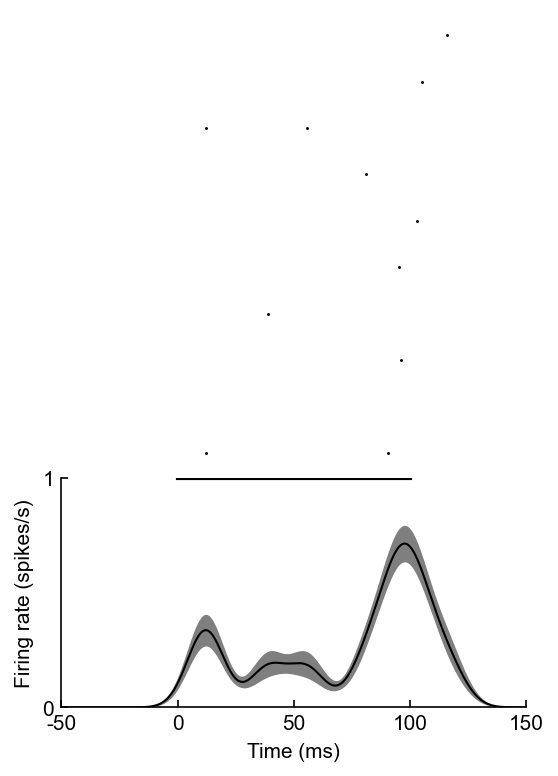

In [24]:
visualizeClusterInternal_short(sessionfile2,187,sessionfile2_laser_start)

(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>, <AxesSubplot:ylabel='Firing rate (spikes/s)'>])

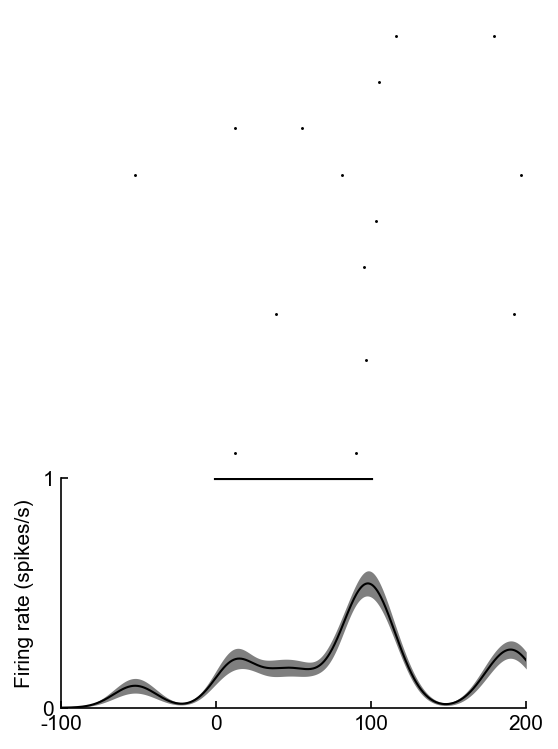

In [25]:
visualizeClusterInternal_short2(sessionfile2,187,sessionfile2_laser_start)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


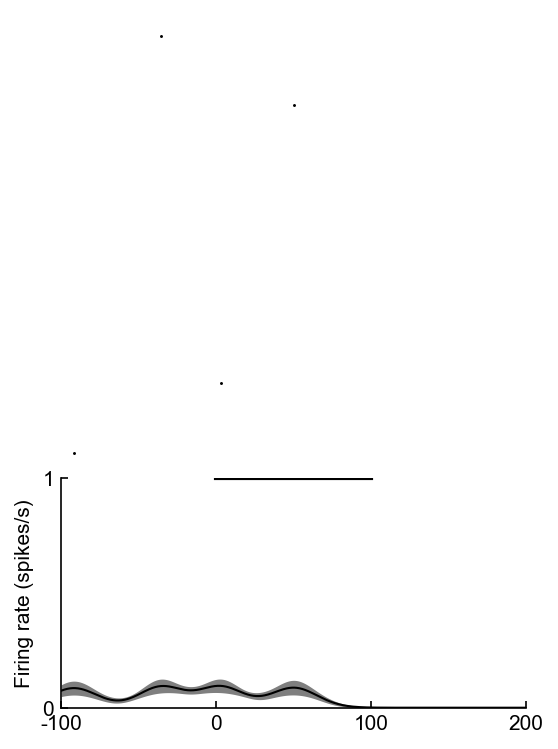

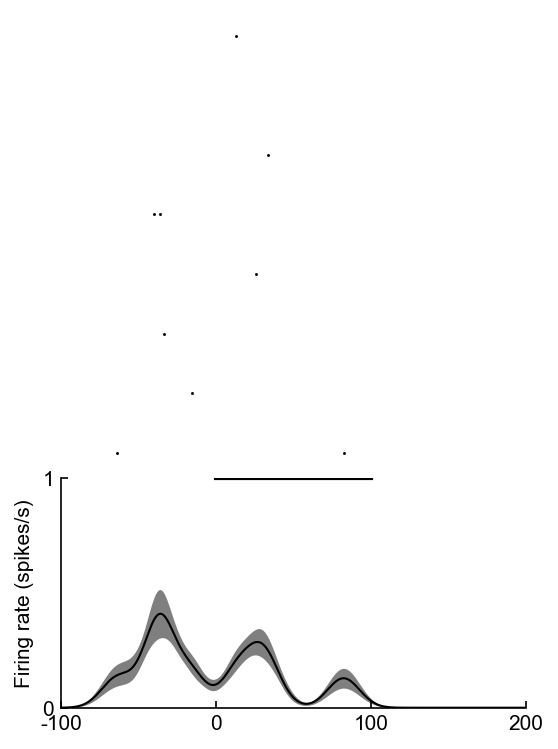

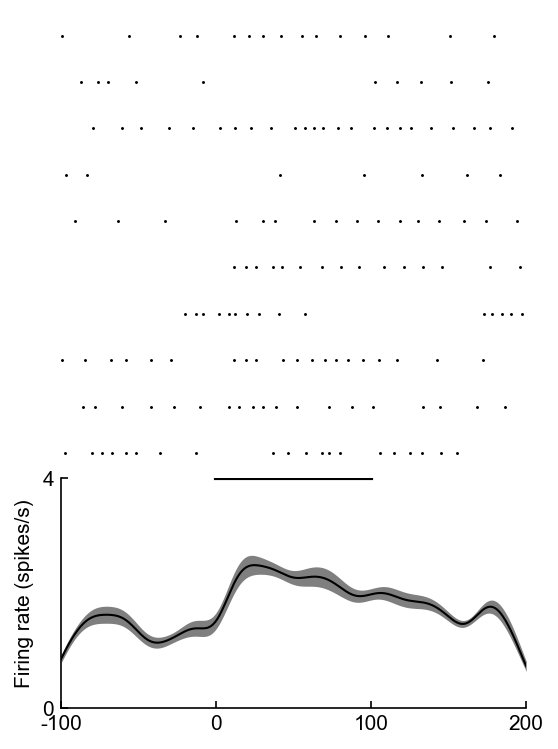

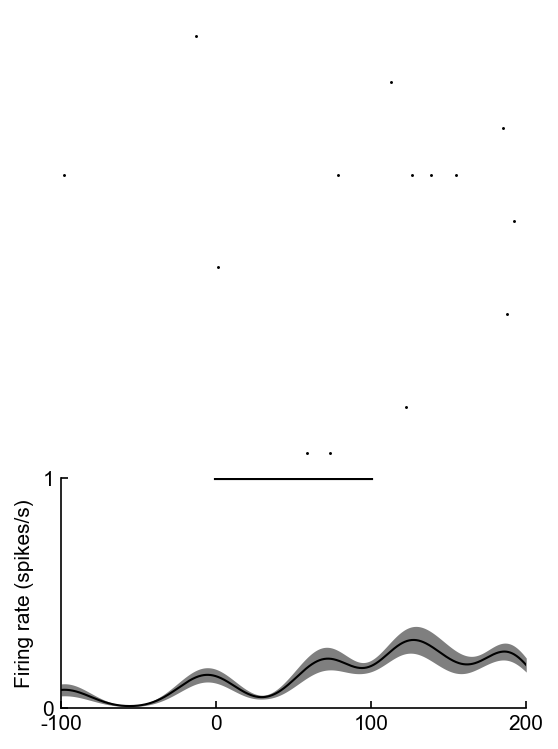

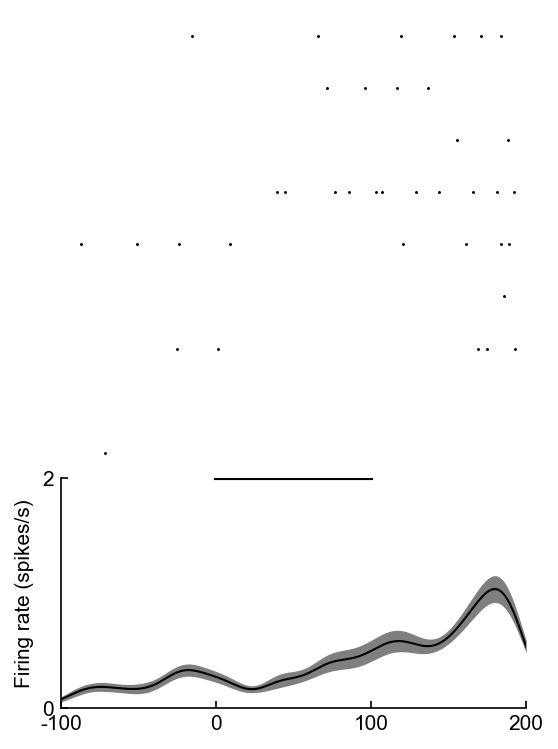

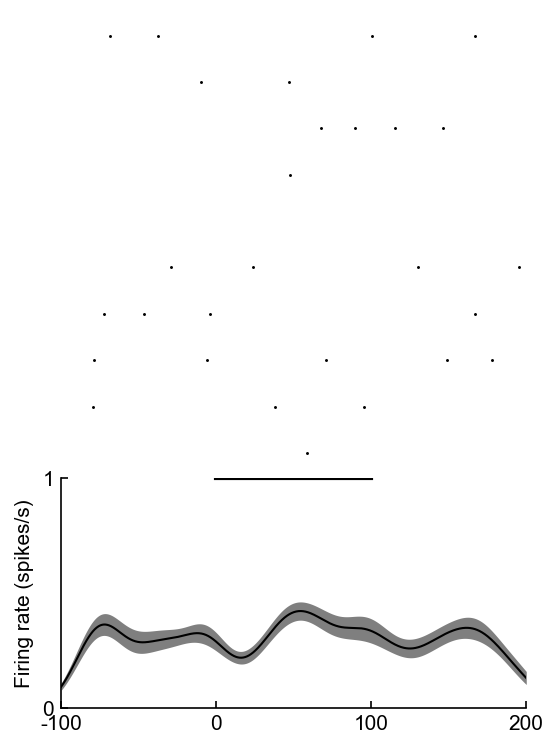

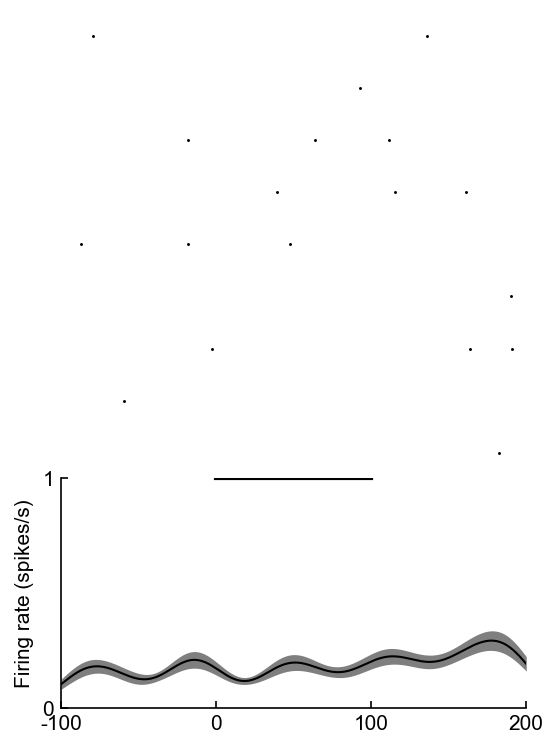

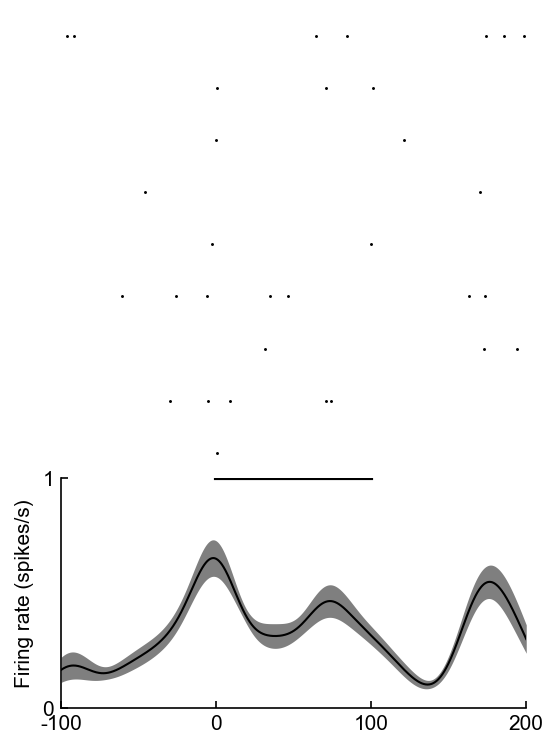

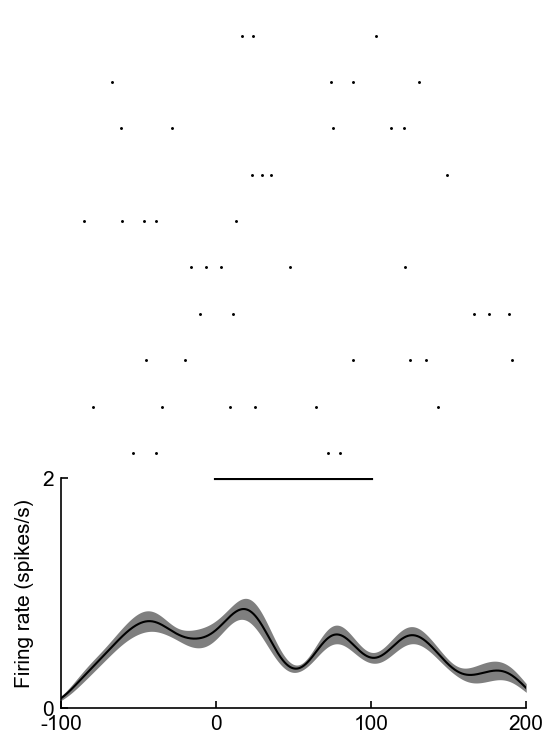

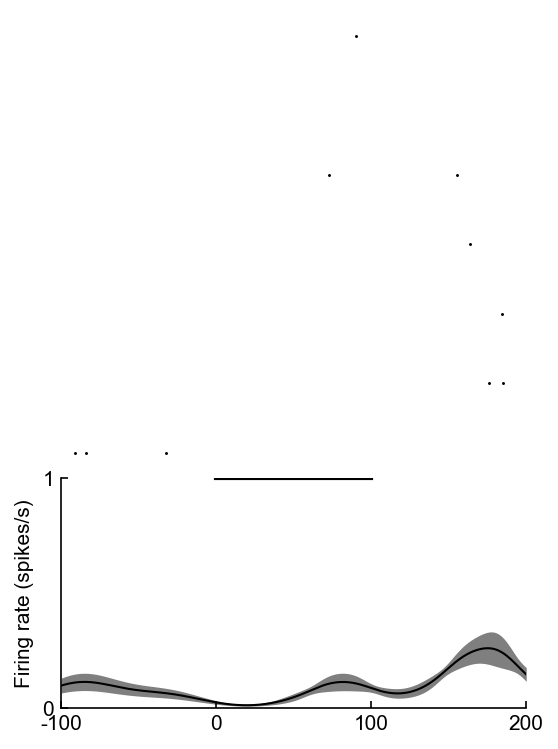

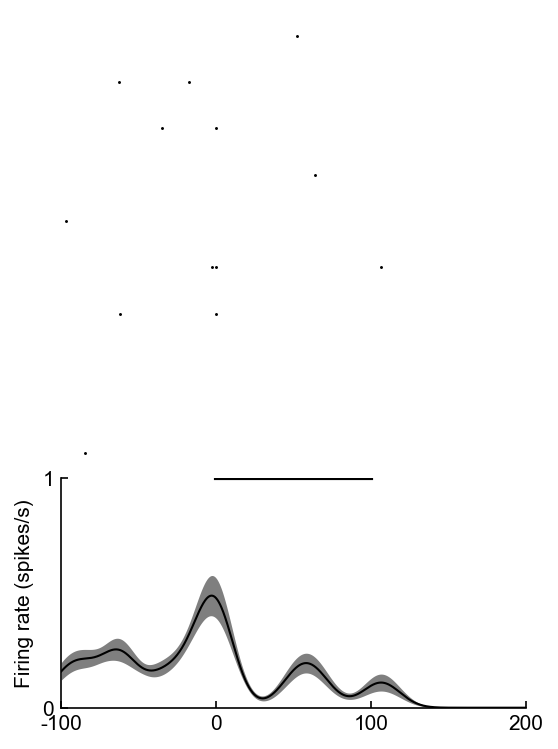

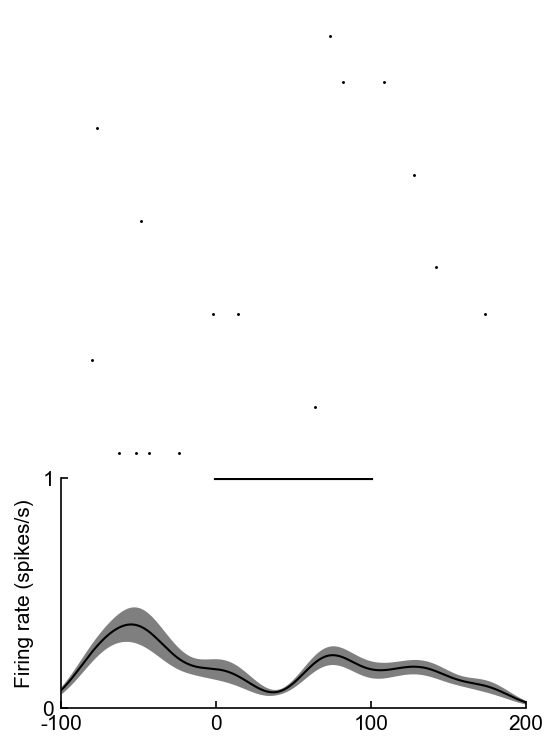

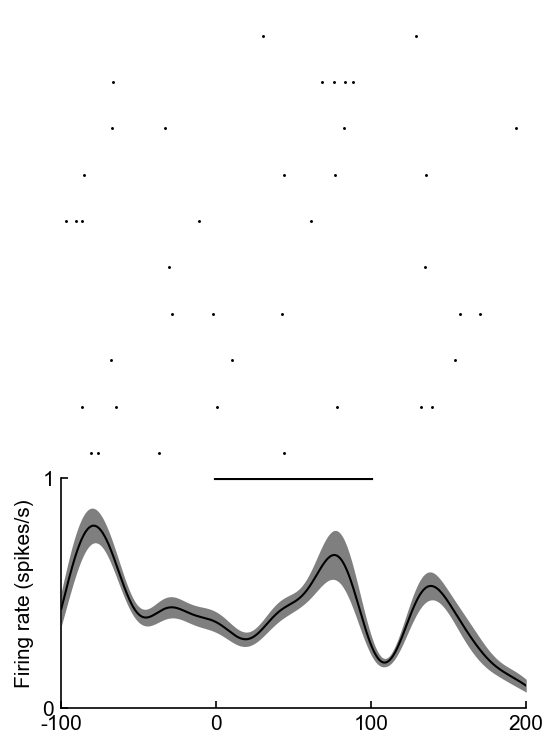

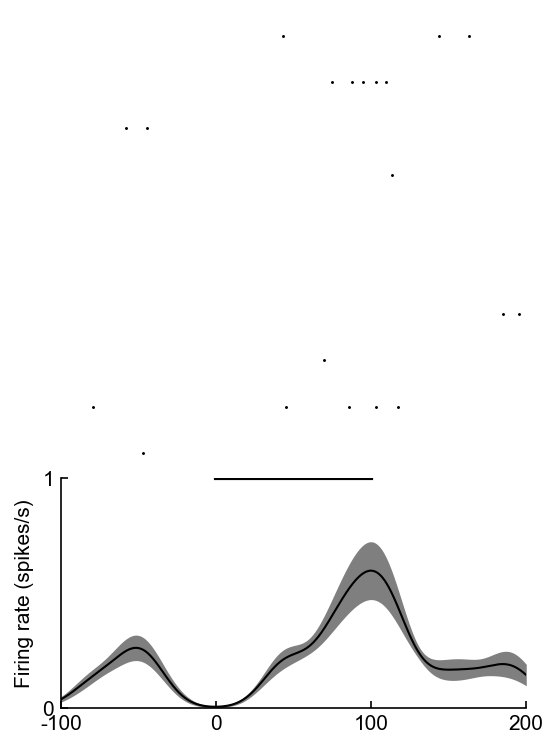

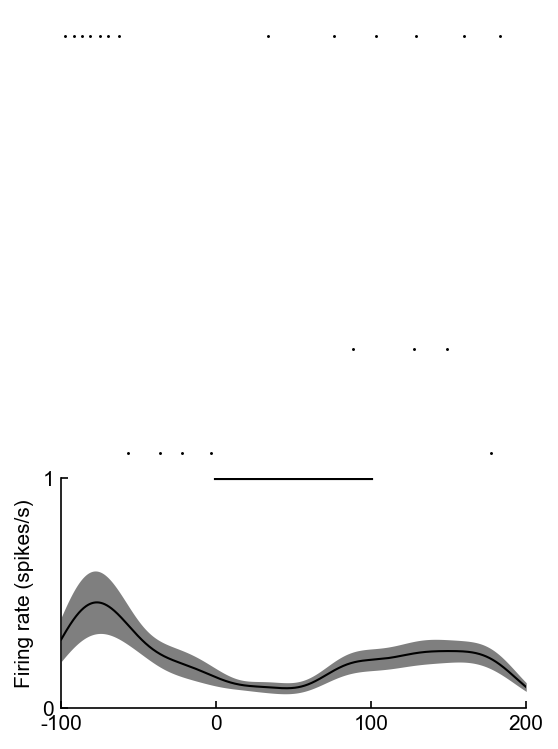

In [8]:
for clust in sessionfile0_goodcells:
    visualizeClusterInternal_short2(sessionfile0,clust,sessionfile0_laser_start)

In [14]:
sessionfile1_goodcells

[108, 134, 138, 161, 170]

In [ ]:
for clust in sessionfile1_goodcells:
    visualizeClusterInternal_short2(sessionfile1,clust,sessionfile1_laser_start)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


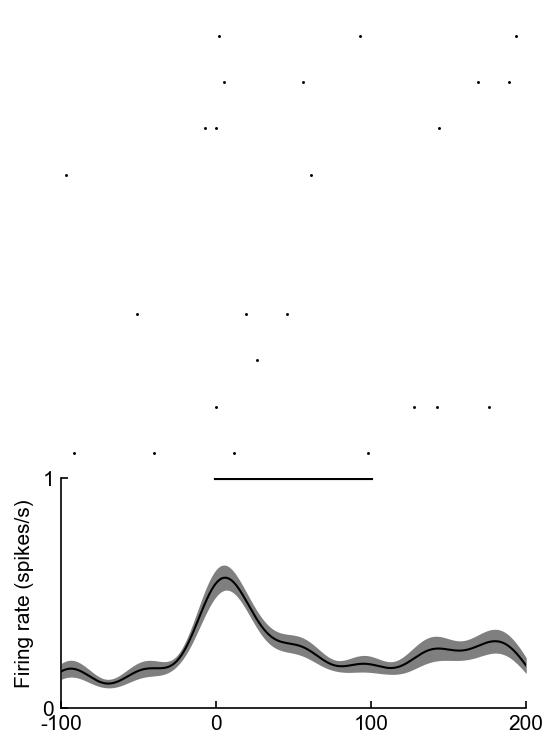

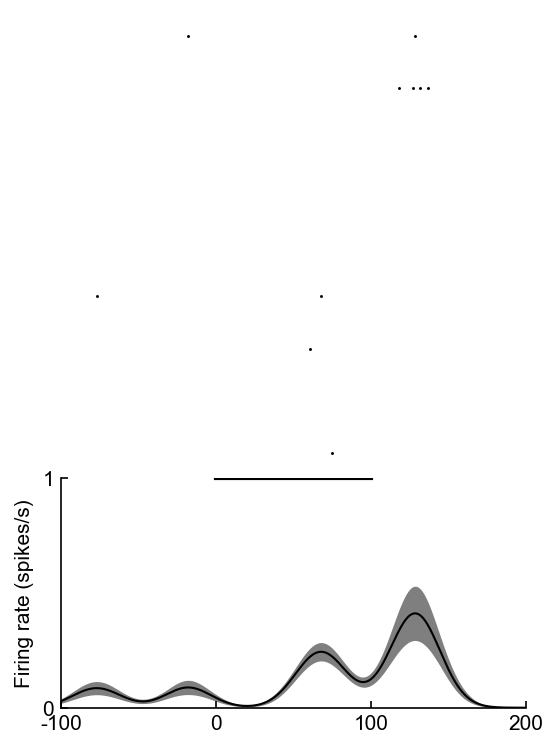

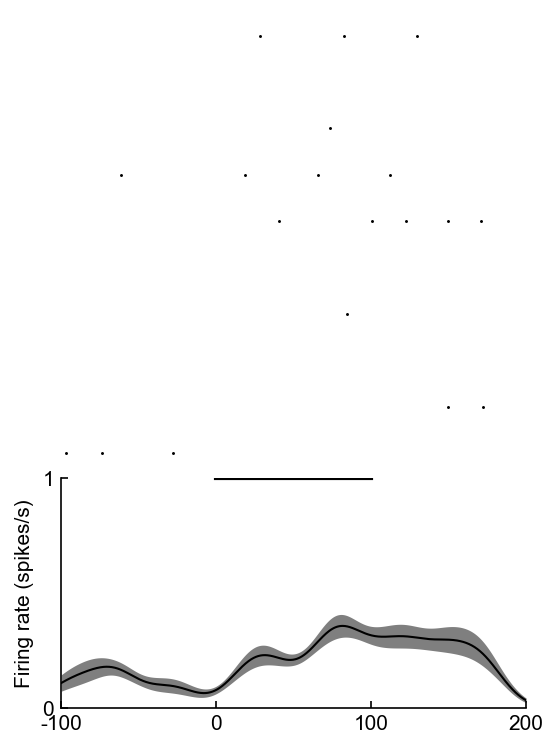

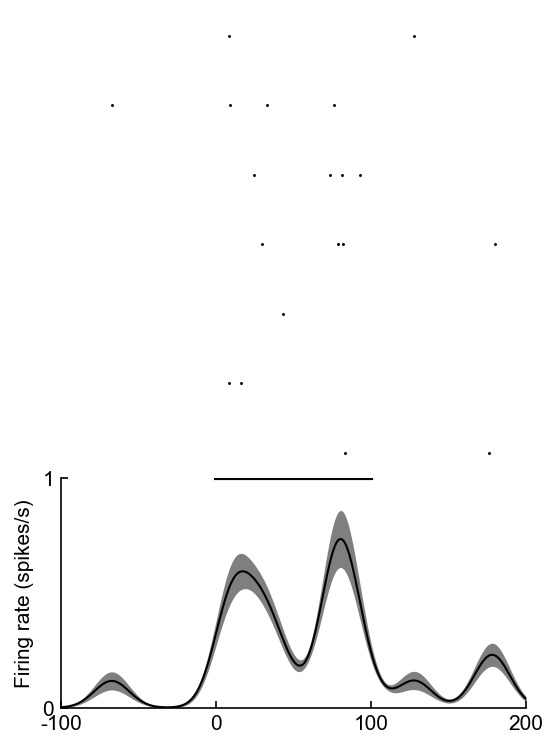

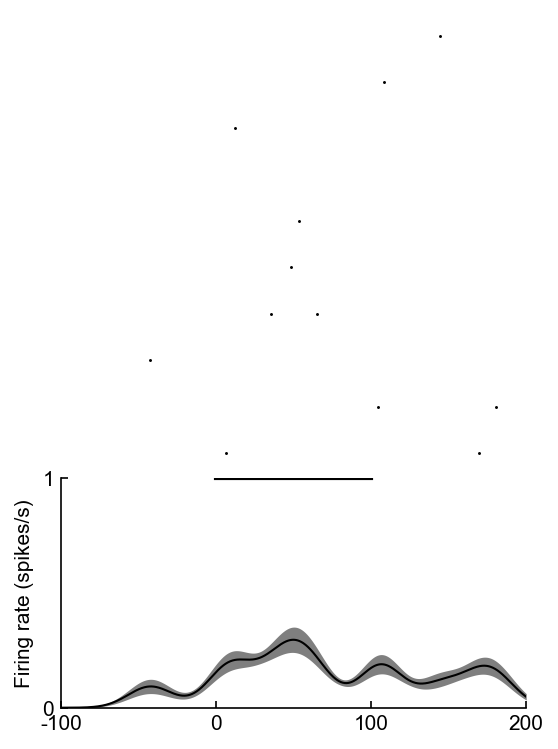

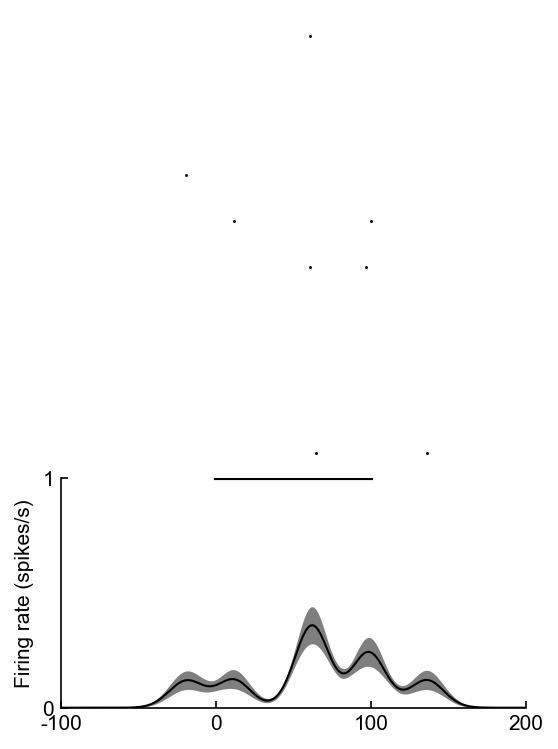

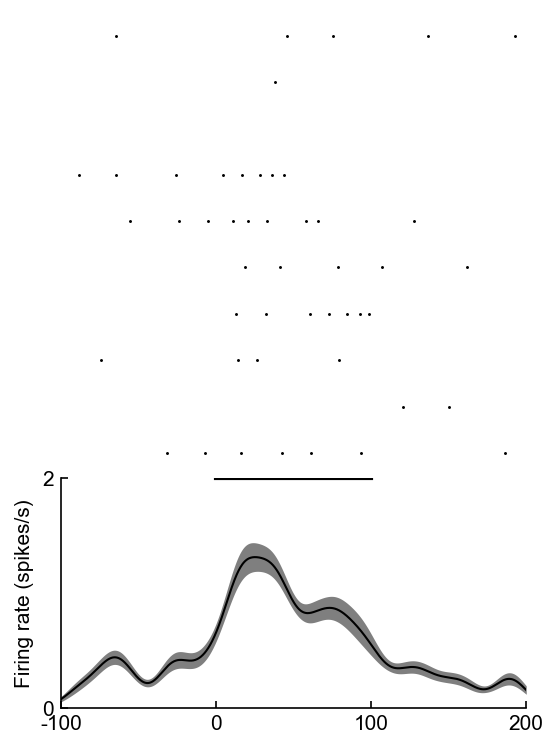

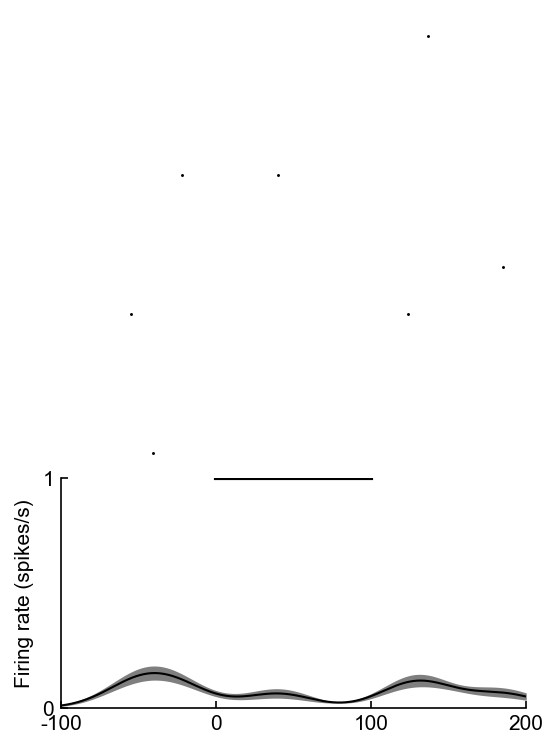

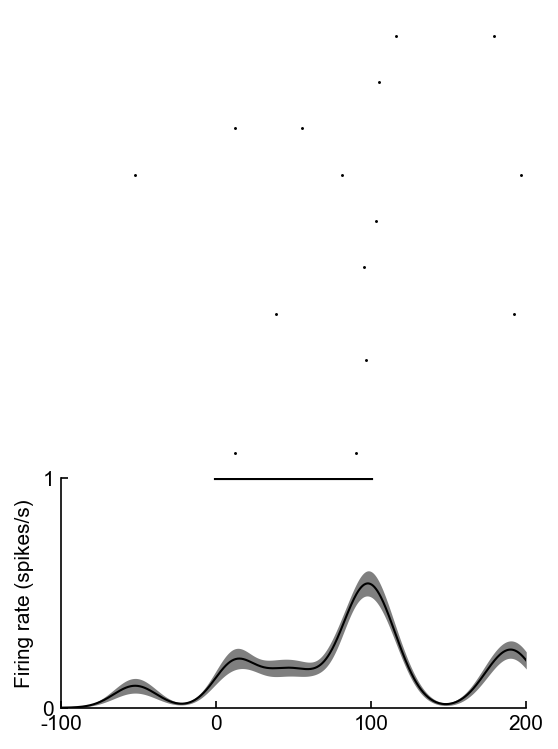

In [22]:
sessionfile2_goodcells = [15, 32, 54, 55, 141, 147, 156, 185, 187]
#visualizeClusterInternal_short2(sessionfile2,13,sessionfile2_laser_start)
for clust in sessionfile2_goodcells:
    visualizeClusterInternal_short2(sessionfile2,clust,sessionfile2_laser_start)

In [26]:
sessionfile0_laser_start

array([ 206812,  299660,  392555,  485415,  578281,  671139,  763998,
        856866,  949719, 1042569], dtype=uint32)

In [27]:
sessionfile1_laser_start

array([ 36821, 129737, 222623, 315535, 408444, 501349, 594251, 687179,
       780124, 873021], dtype=uint32)

In [28]:
sessionfile2_laser_start

array([125804, 218712, 311615, 404540, 497439, 590342, 683264, 776183,
       869106, 962010], dtype=uint32)

### laser time = 2s

In [41]:
sessionfile0_laser_start = sessionfile0.trials.laser_events[0][10:]

sessionfile1_laser_start = sessionfile1.trials.laser_events[0][10:]

sessionfile2_laser_start = sessionfile2.trials.laser_events[0][10:]

In [42]:
sessfionfile0_labels = sessionfile0.clusters.labels
sessionfile0_goodcells = [num for num, label in sessfionfile0_labels.items() if label == 'good']

sessfionfile1_labels = sessionfile1.clusters.labels
sessionfile1_goodcells = [num for num, label in sessfionfile1_labels.items() if label == 'good']

sessfionfile2_labels = sessionfile2.clusters.labels
sessionfile2_goodcells = [num for num, label in sessfionfile2_labels.items() if label == 'good']

In [47]:
def visualizeClusterInternal_long(sessionfile,clust,sessionfile_laser_start):
    bw_scott_factor = 3
    
    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_xlim([-30000,90000])
    
    
    color_to_use = 'black'

    #########################

    trialSpikes = []
    for laser_start in sessionfile_laser_start:
 
        starttime = laser_start - 1*30000
        endtime = laser_start + 3*30000
        this_trial_spike = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime, endtime=endtime)
        this_trial_spike= this_trial_spike.astype(int)
        spiketoplot =  (this_trial_spike) - (laser_start)
        trialSpikes.append(spiketoplot)
        
    trialSpikes = np.array(trialSpikes,dtype='object') 
    #print(trialSpikes)
    #Plot Raster
    for idx,trial in enumerate(sessionfile_laser_start):
        ax1.scatter(trialSpikes[idx],np.ones_like(trialSpikes[idx])*idx,color=color_to_use,s=2,marker='o',lw=0)    

    
    #Plot PSTH
    starttime = -30000
    endtime = 90000
    PSTHstart = starttime - 50
    PSTHend = endtime + 50
    xrange = np.linspace(starttime,endtime,num=1000)
    numSplits = min(10,len(trialSpikes))
    if numSplits < 2:
        return False,[] ### Return a failure
    
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes)):
        PSTHspikes = np.concatenate(trialSpikes[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR,lw=1,color=color_to_use)
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color=color_to_use,alpha=0.5,zorder=-10,lw=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit])
    ax2.set_yticklabels(['0',str(limit)])
    
    
    ax2.set_ylabel('Firing rate (spikes/s)')
    ax2.plot([0,60000],[limit,limit],color='k',lw=2,linestyle='-') #zorder = 10 line of tone

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([-30000,0,60000,90000])
    ax2.set_xticklabels(['-1000','0','2000','3000'])
    ax2.set_xlabel('Time (ms)')
    

    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\AE_M2Test\\11\\'+str(clust)+'long'+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\AE_M2Test\\22\\'+str(clust)+'long'+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\AE_M2Test\\33\\'+str(clust)+'long'+'.pdf'),transparent=False,facecolor="white", bbox_inches = 'tight')
    
    return fig,[ax1,ax2]

    

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


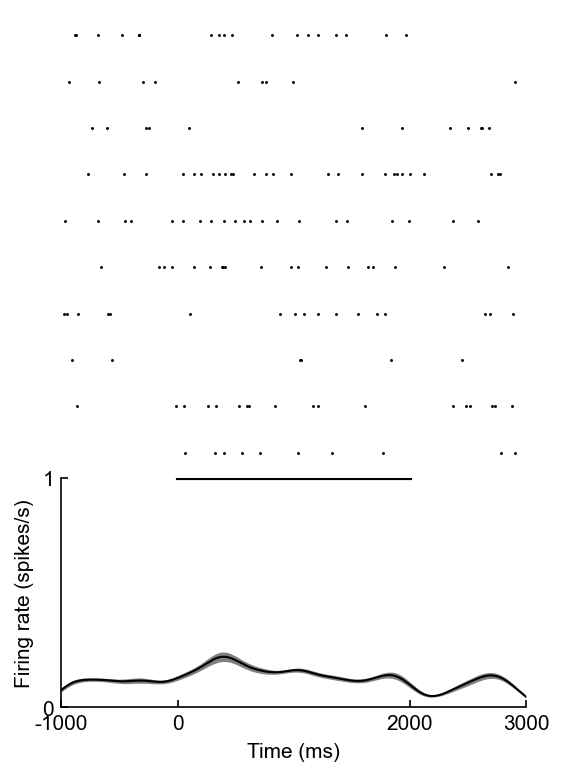

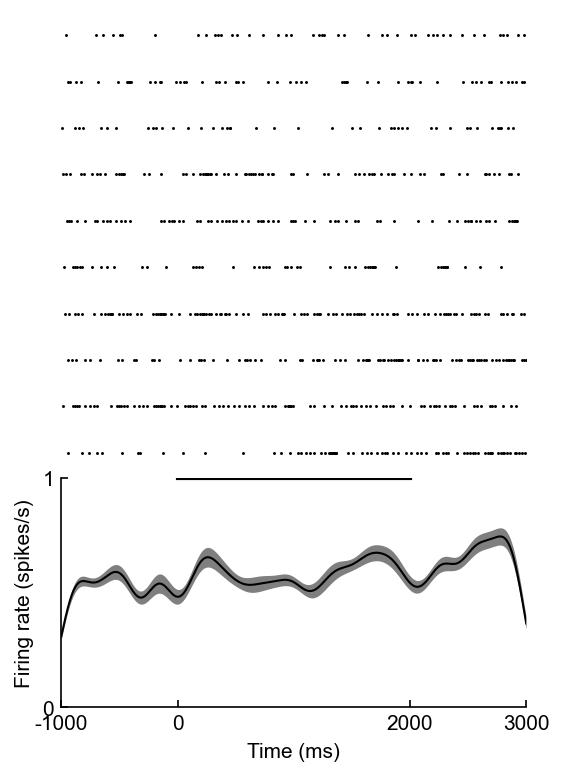

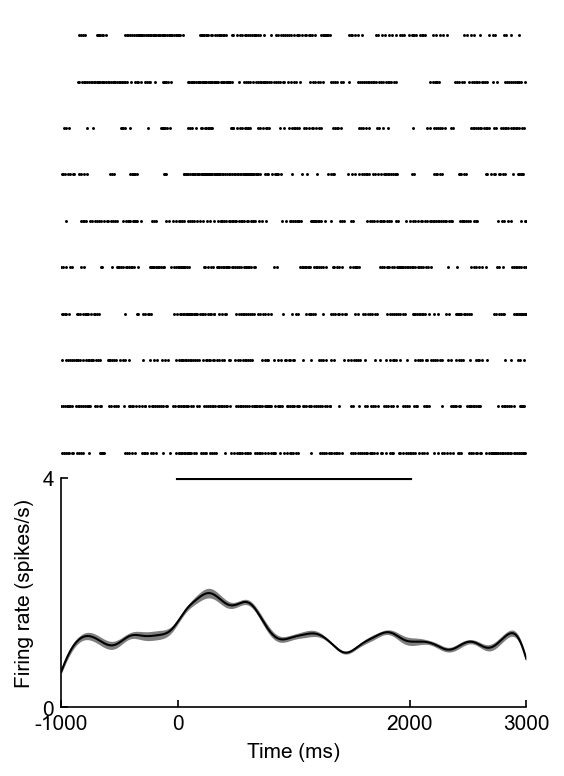

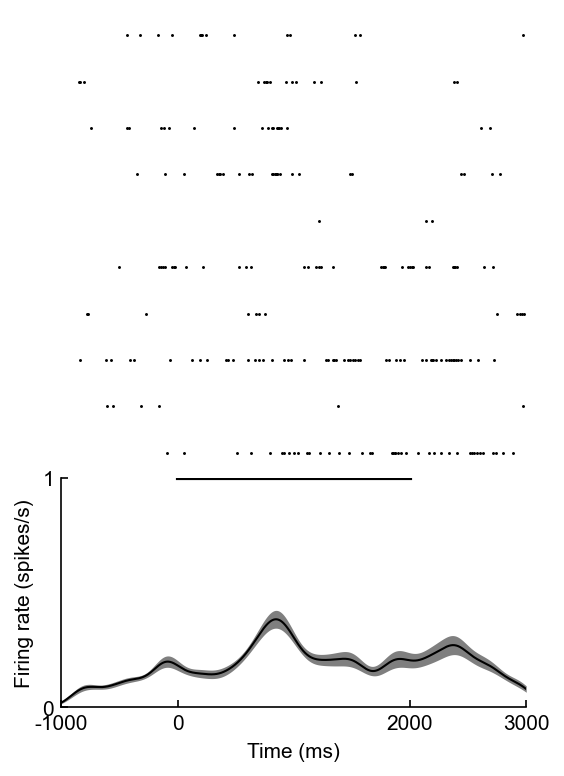

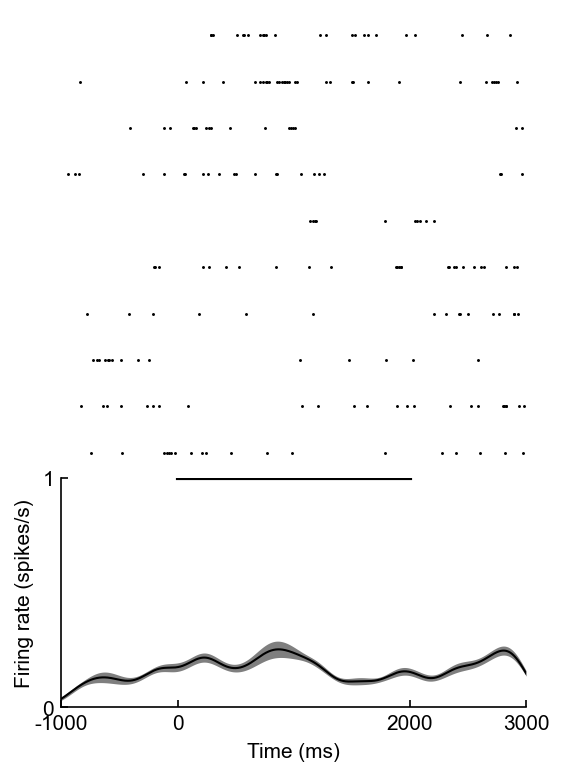

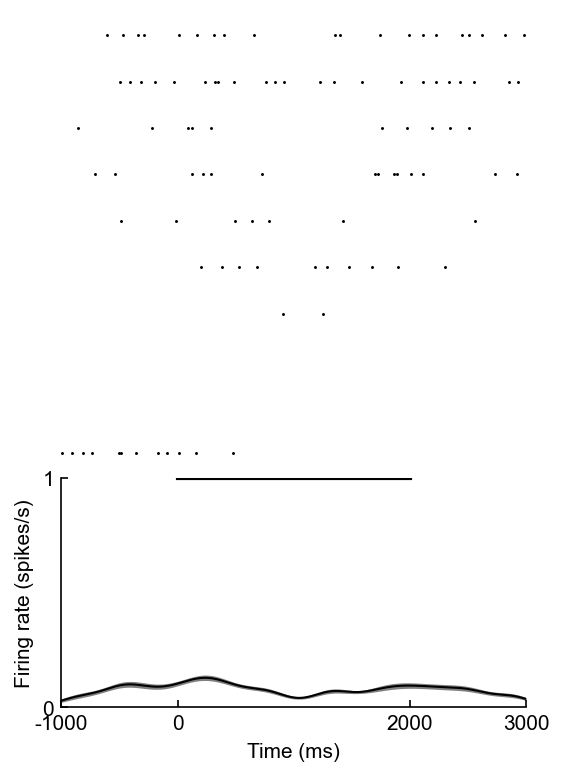

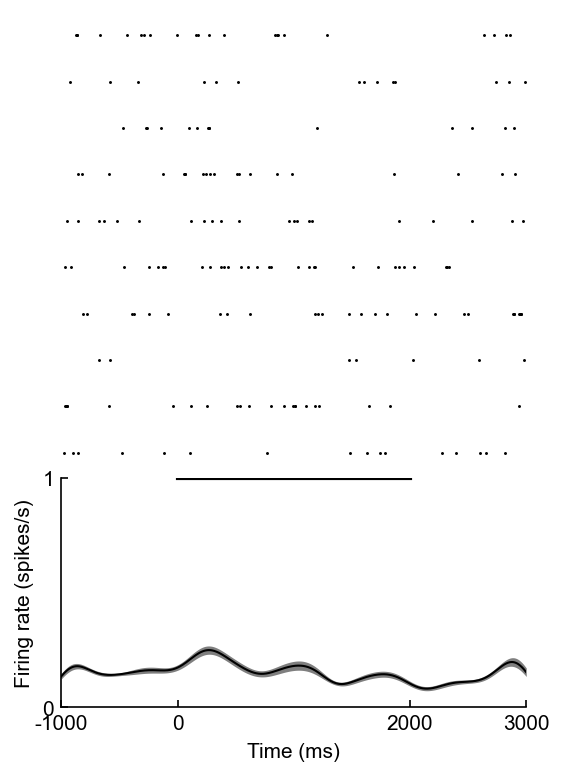

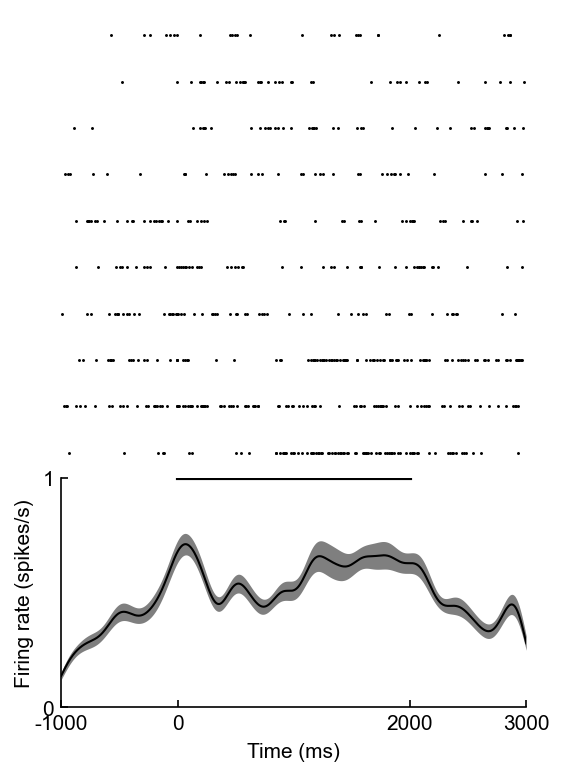

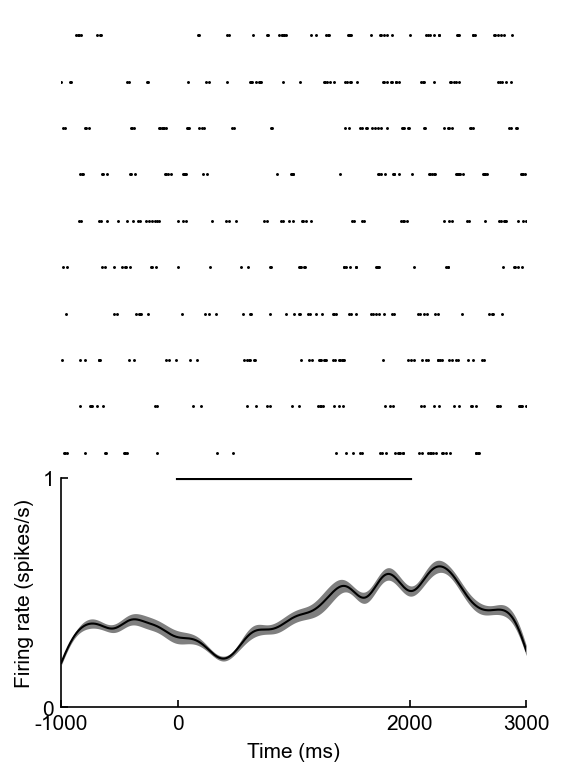

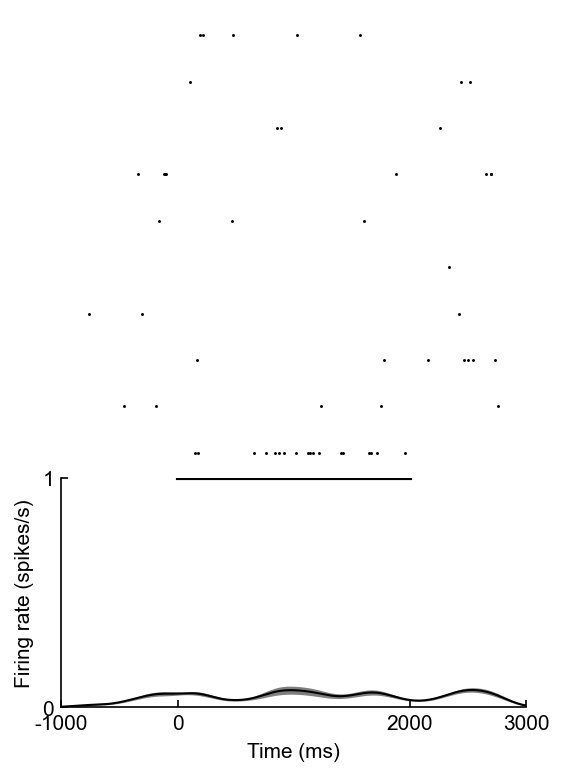

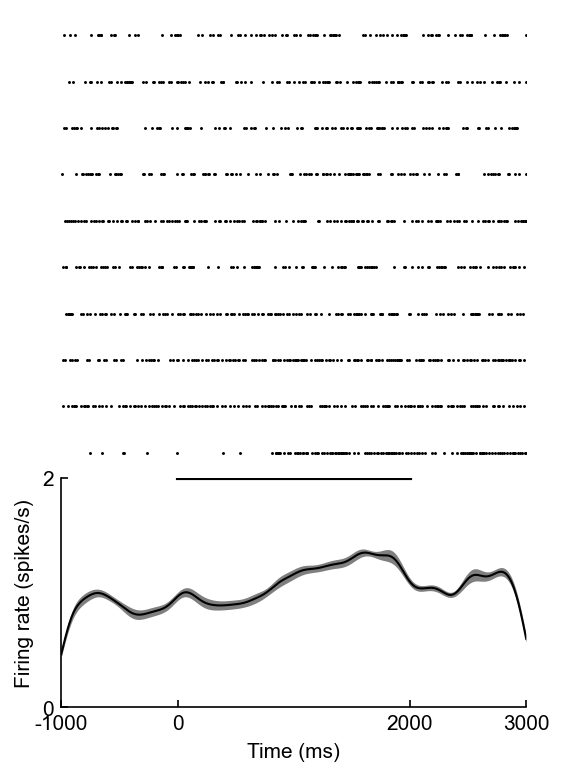

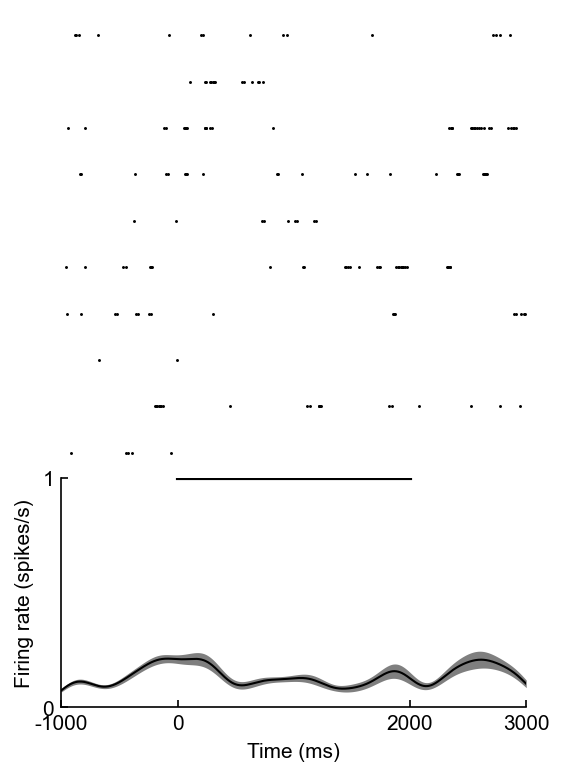

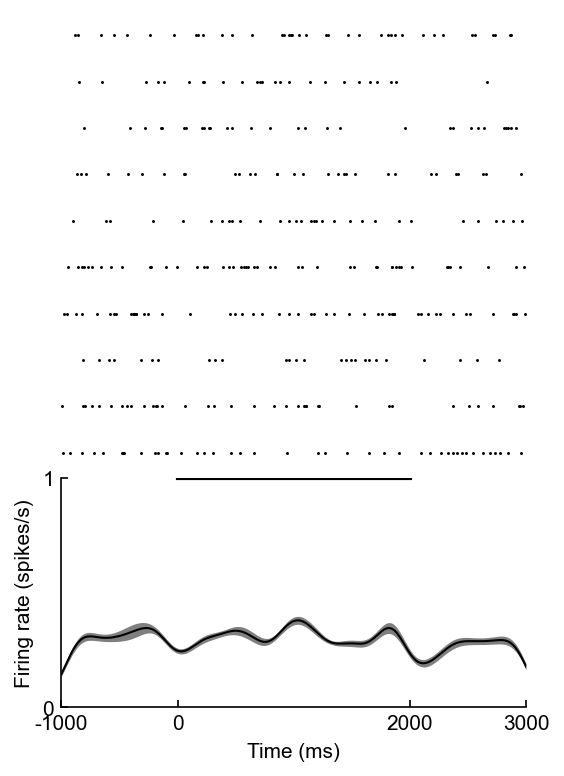

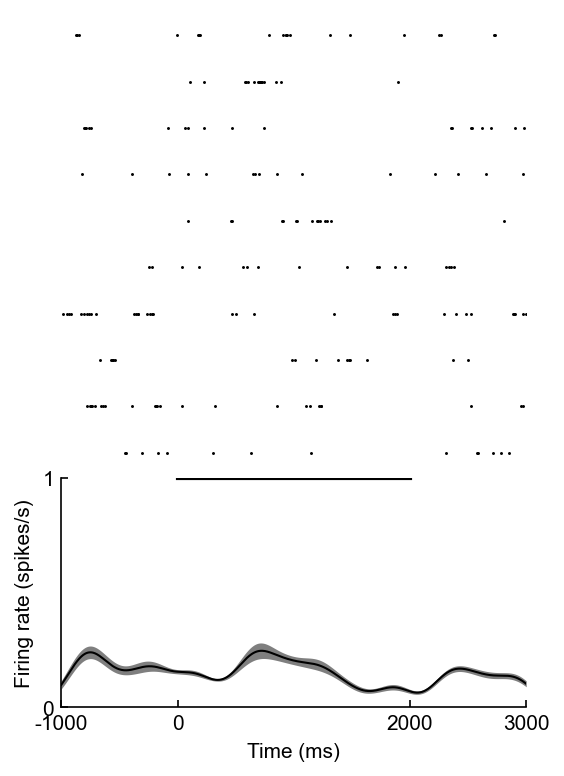

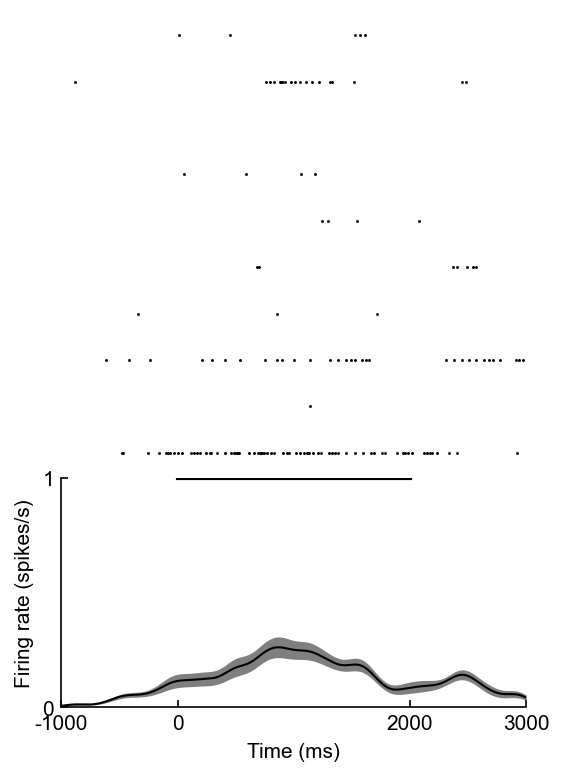

In [44]:
for clust in sessionfile0_goodcells:
    visualizeClusterInternal_long(sessionfile0,clust,sessionfile0_laser_start)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


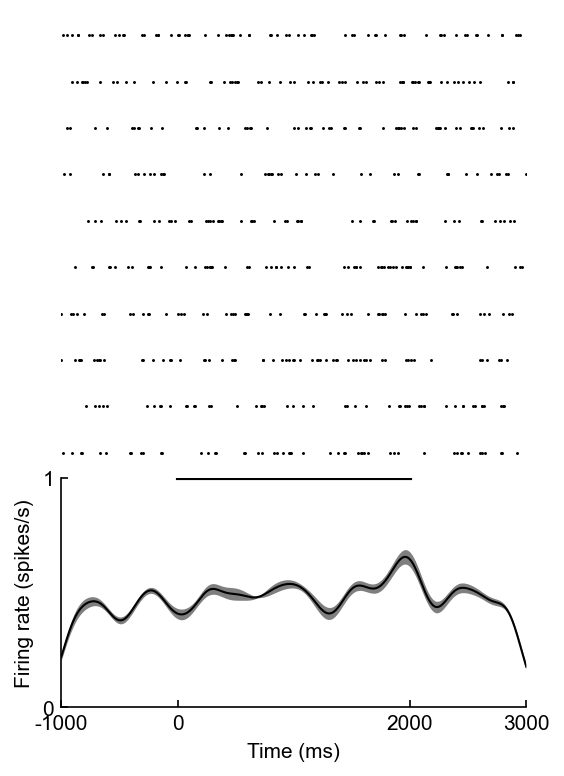

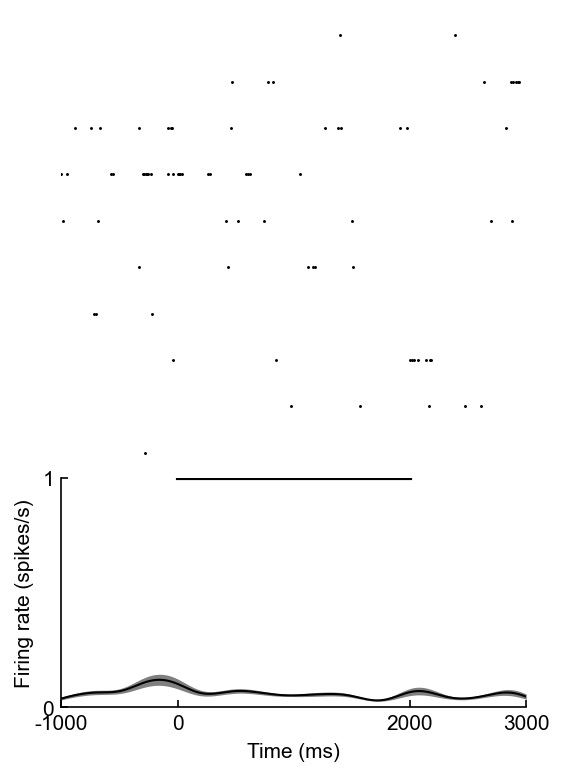

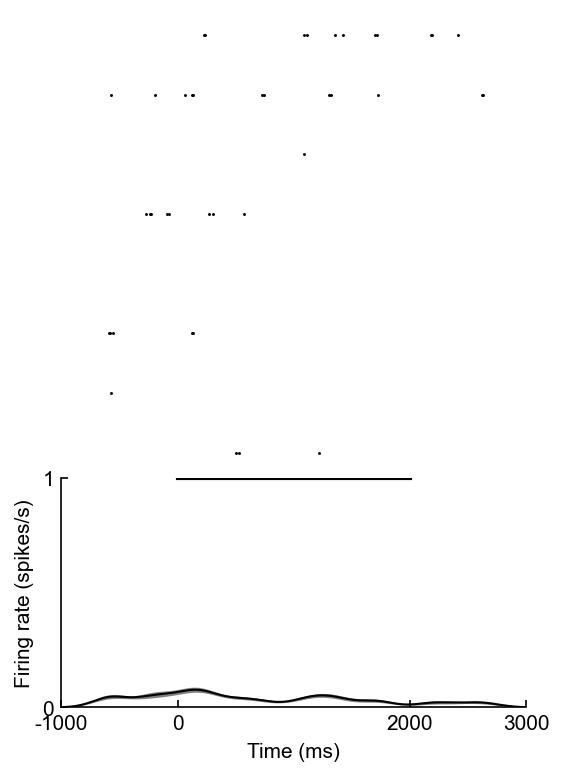

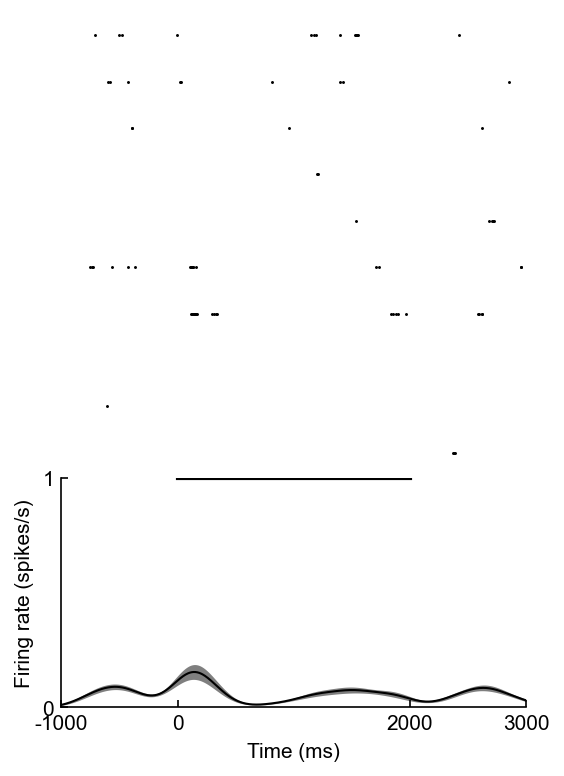

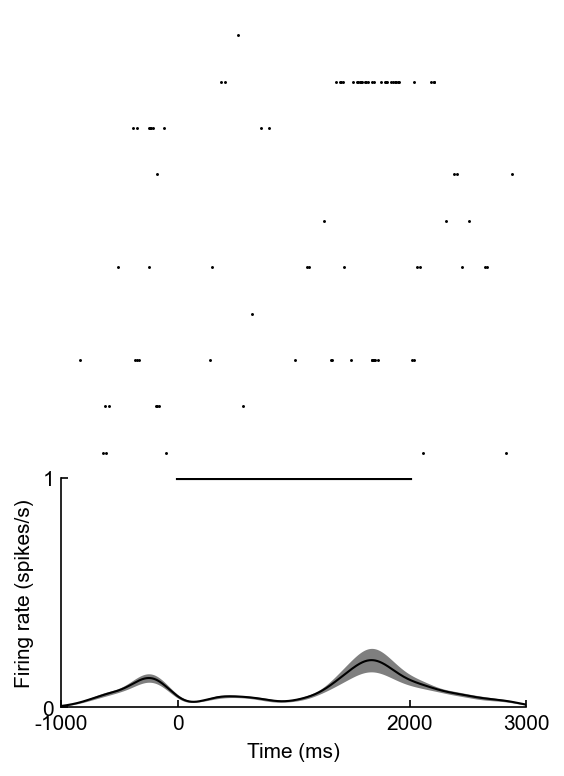

In [46]:
for clust in sessionfile1_goodcells:
    visualizeClusterInternal_long(sessionfile1,clust,sessionfile1_laser_start)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


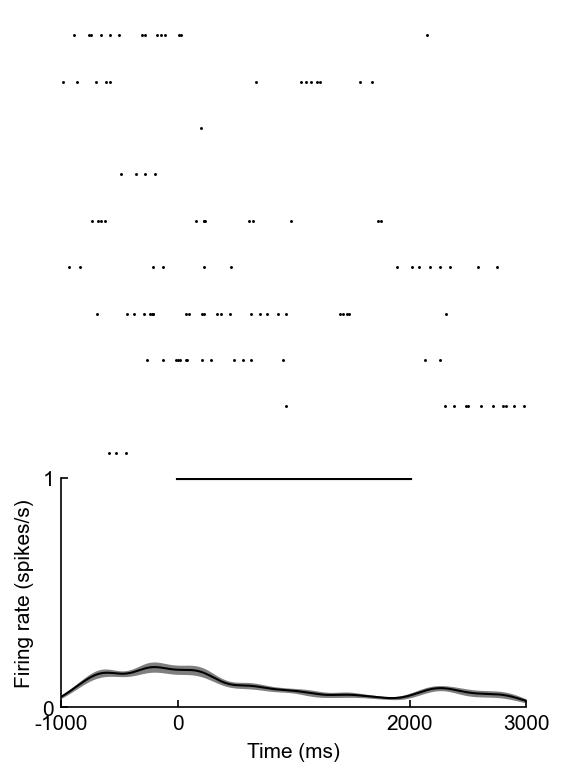

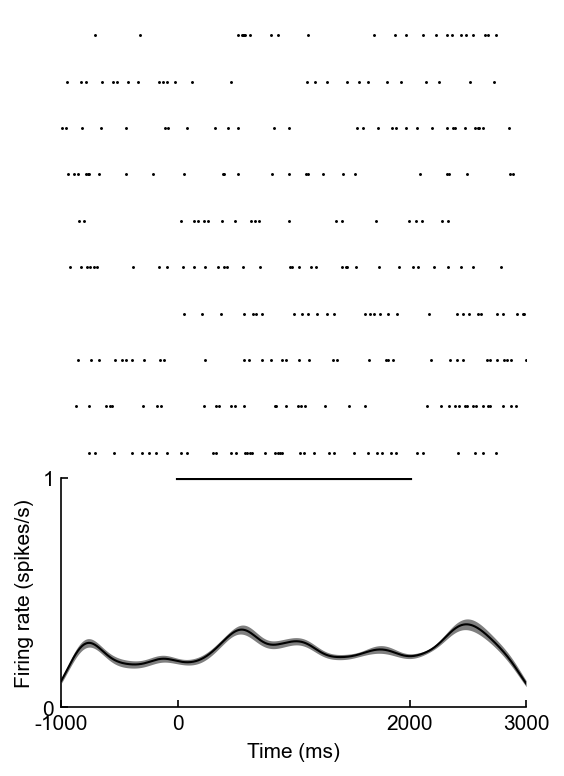

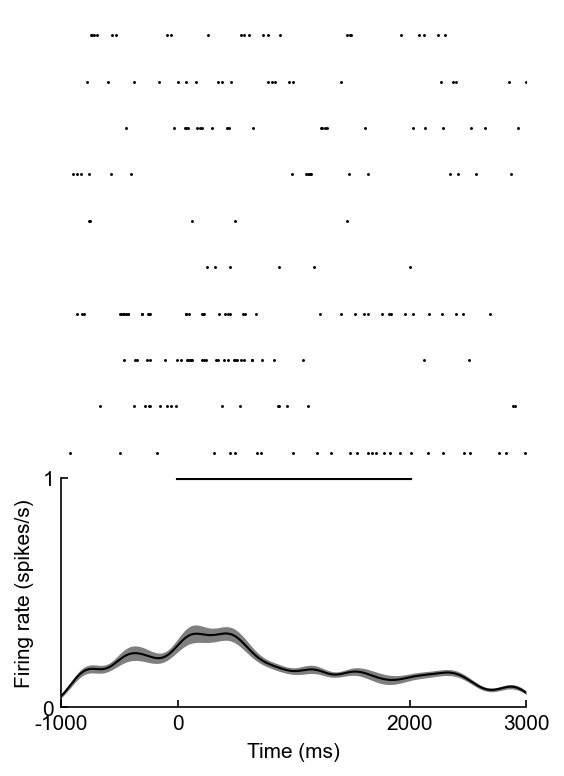

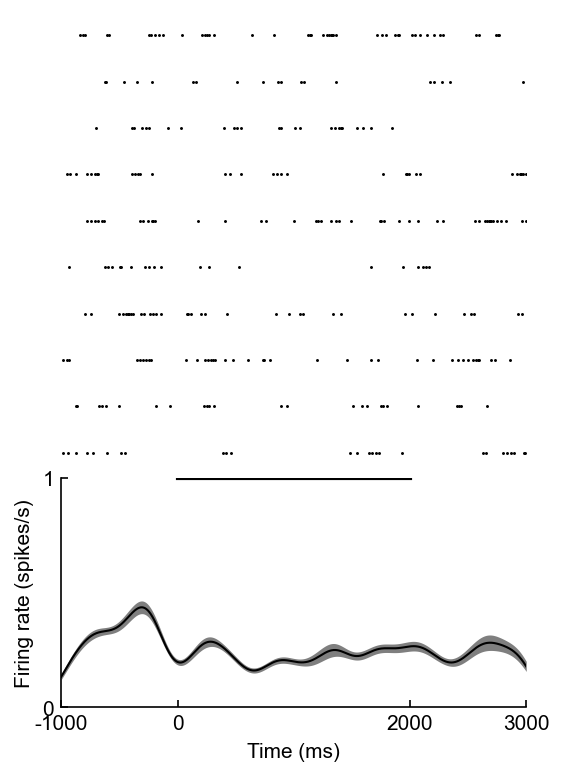

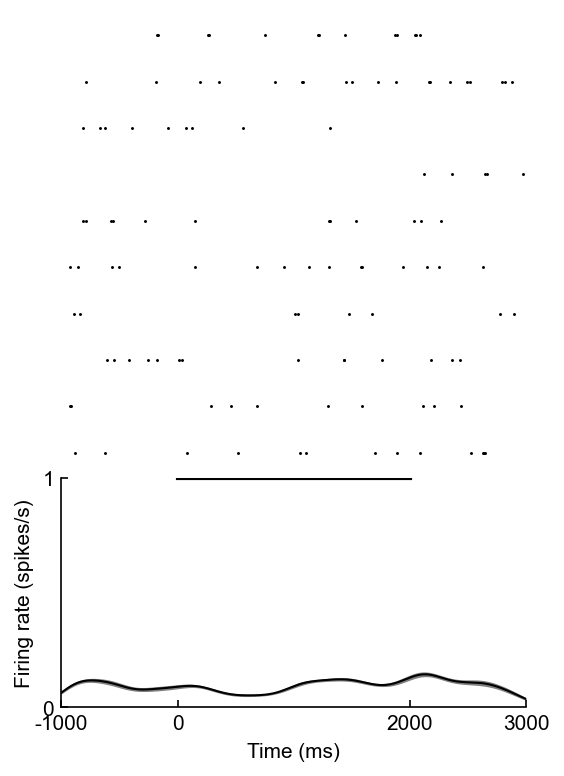

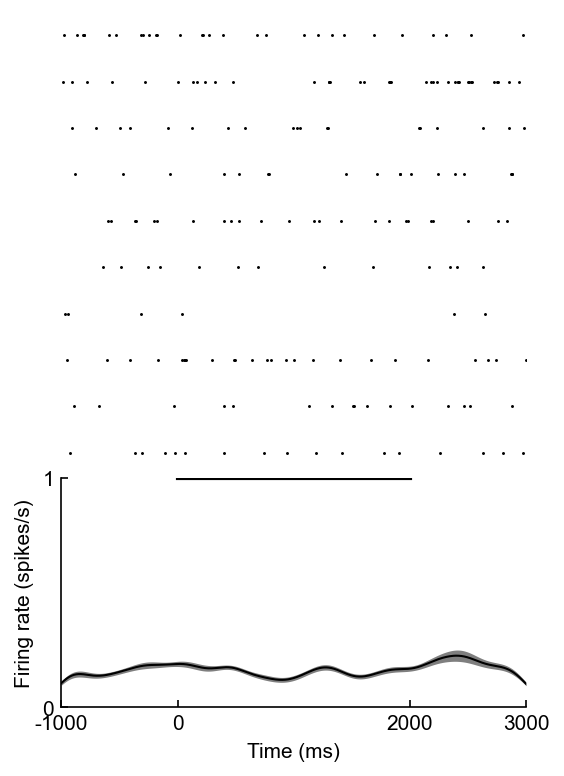

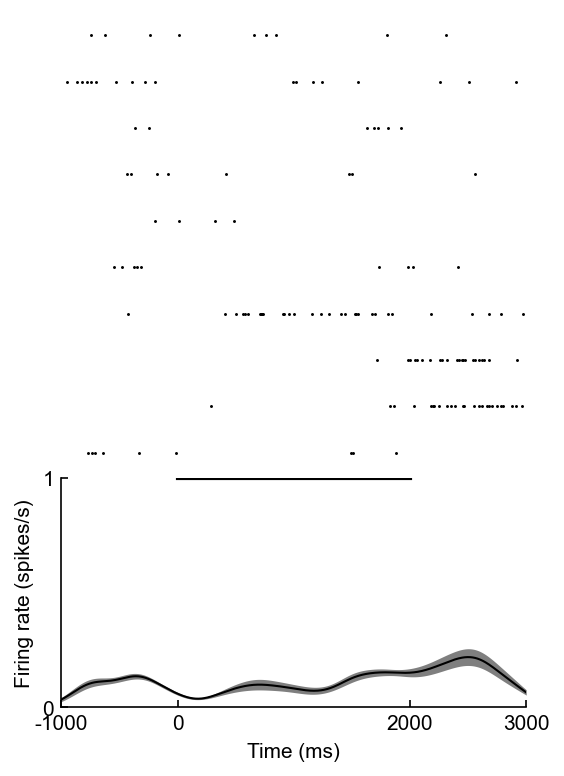

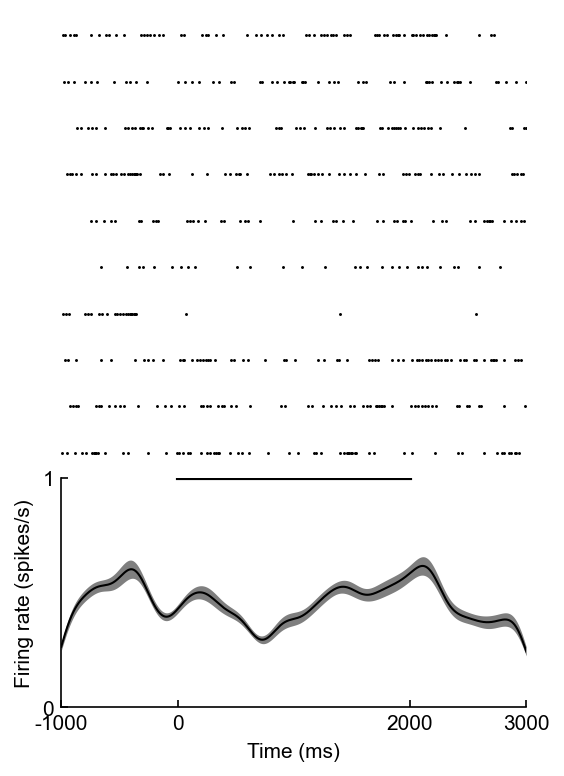

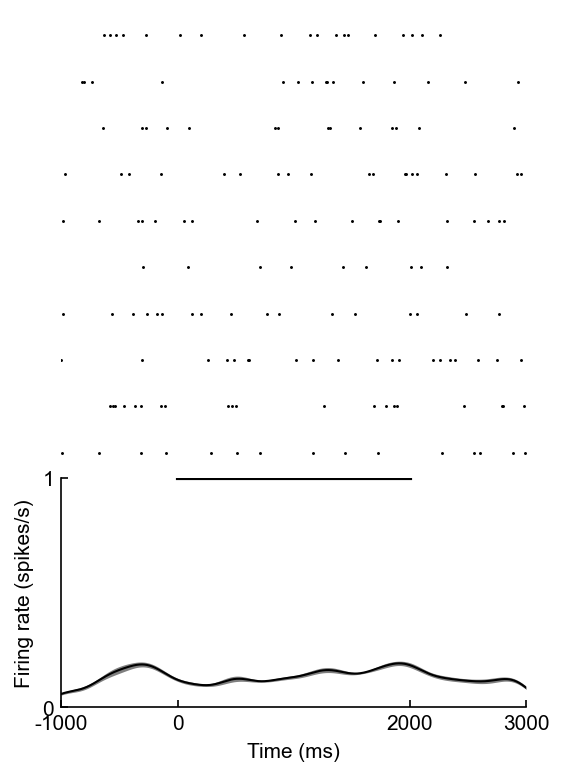

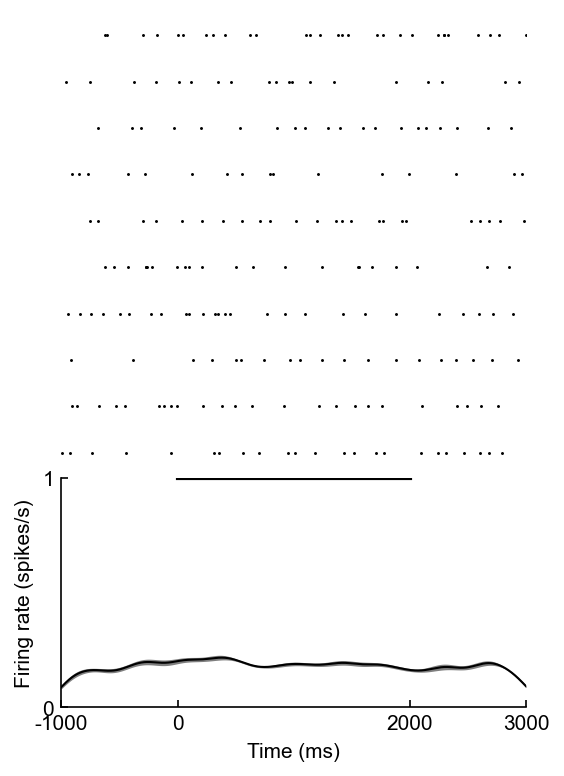

In [48]:
for clust in sessionfile2_goodcells:
    visualizeClusterInternal_long(sessionfile2,clust,sessionfile2_laser_start)